In [1]:
import os
import random
import time
import collections
import itertools
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pickle
import seaborn as sns

from scipy.stats import entropy
from innvariant_dgl.dataset import ConstructionSequenceDataset, generate_ba_model_construction_sequence, graph_to_construction_sequence, construction_sequence_to_graph, generate_ws_model_construction_sequence
from tqdm import tqdm

In [2]:
with open('deepgg-combined.pkl', 'rb') as read_handle:
    C = pickle.load(read_handle)

In [3]:
keys = list(C.keys())
keys_dfs = [key for key in keys if '_dfs' in key]
keys_bfs = [key for key in keys if '_bfs' in key]
keys_process = [key for key in keys if '_process' in key]
keys_erdos_renyi = [key for key in keys if 'erdos_renyi' in key]
keys_barabasi_albert = [key for key in keys if 'barabasi_albert' in key]
keys_watts_strogatz = [key for key in keys if 'watts_strogatz' in key]
keys_er_and_bfs = [key for key in keys if 'erdos_renyi' in key and '_bfs' in key]
keys_er_and_dfs = [key for key in keys if 'erdos_renyi' in key and '_dfs' in key]
keys_ba_and_bfs = [key for key in keys if 'barabasi_albert' in key and '_bfs' in key]
keys_ba_and_dfs = [key for key in keys if 'barabasi_albert' in key and '_dfs' in key]
keys_ws_and_bfs = [key for key in keys if 'watts_strogatz' in key and '_bfs' in key]
keys_ws_and_dfs = [key for key in keys if 'watts_strogatz' in key and '_dfs' in key]

subsets = {
    'Depth-First-Search': keys_dfs,
    'Breadth-First-Search': keys_bfs,
    'Construction Process': keys_process,
    'Erdos-Renyi model': keys_erdos_renyi,
    'Barabasi-Albert model': keys_barabasi_albert,
    'Watts-Strogatz model': keys_watts_strogatz,
    'Erdos-Renyi + BFS': keys_er_and_bfs,
    'Erdos-Renyi + DFS': keys_er_and_dfs,
    'Barabasi-Albert + BFS': keys_ba_and_bfs,
    'Barabasi-Albert + DFS': keys_ba_and_dfs,
    'Watts-Strogatz + BFS': keys_ws_and_bfs,
    'Watts-Strogatz + DFS': keys_ws_and_dfs,
}

In [4]:
# Utility functions

In [5]:
def count_graphs_degree(graph_list: list):
    degree_count = collections.Counter()

    for graph in graph_list:
        degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)
        degree_count.update(degree_sequence)
    return degree_count

def count_cs_degree(ds_construction_sequences: list):
    return count_graphs_degree([construction_sequence_to_graph(seq) for seq in ds_construction_sequences])

def graph_degree_counter_to_histogram(counter_degree: collections.Counter, degrees_sorted: list=None):
    if degrees_sorted is None:
        degrees_sorted = sorted([d for d in sorted(counter_degree)])
        
    return [counter_degree.get(d) if counter_degree.get(d) is not None else 0 for d in degrees_sorted]

def get_degree_histogram(graph_list: list, degrees_sorted: list=None):
    counter_degree = count_graphs_degree(graph_list)

    return graph_degree_counter_to_histogram(counter_degree(graph_list), degrees_sorted)

def plot_count(count: collections.Counter, title='', label=''):
    deg, cnt = zip(*count.items())
    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')
    plt.title('Histogram %s' % title)
    plt.ylabel('Count')
    plt.xlabel(label)
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)
    plt.show()

def kl_divergence(p, q):    
    p = np.asarray(p, dtype=np.float)
    q = np.asarray(q, dtype=np.float)

    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [7]:
C[keys[0]].keys()

dict_keys(['meta', 'base_path', 'dataset_cs', 'generated_cs', 'computation_time'])

In [62]:
def plot_degree_samples(keys: list, num_samples: int = 3):
    sns.set(style="whitegrid")
    sns.set(font_scale=2)

    for key in random.sample(keys, num_samples):

        num_cs_dataset = len(C[key]['dataset_cs'])
        num_cs_generated = len(C[key]['generated_cs'])

        graphs_dataset = [construction_sequence_to_graph(seq) for seq in C[key]['dataset_cs']]
        graphs_generated = []
        ignoring_generated_graphs = 0
        for seq in C[key]['generated_cs']:
            cur_graph = construction_sequence_to_graph(seq)
            if len(cur_graph) > 5:
                graphs_generated.append(cur_graph)
            else:
                ignoring_generated_graphs += 1
        print('Ignored %s graphs which are too small' % ignoring_generated_graphs)
        print('Considering %s generated graphs' % len(graphs_generated))

        ds_graphs_degree = count_graphs_degree(graphs_dataset)
        generated_graphs_degree = count_graphs_degree(graphs_generated)

        degrees = set([d for d in sorted(generated_graphs_degree)] + [d for d in sorted(ds_graphs_degree)])
        sorted_degrees = sorted(degrees)
        hist_list_generated = np.array([generated_graphs_degree.get(d) if generated_graphs_degree.get(d) is not None else 0 for d in sorted_degrees])
        hist_list_dataset = np.array([ds_graphs_degree.get(d) if ds_graphs_degree.get(d) is not None else 0 for d in sorted_degrees])

        instance_name = key.replace('deepgg-', '').split('-')[0]

        plt.figure(figsize=(20, 1))
        ax = sns.boxplot(hist_list_dataset/num_cs_dataset)
        ax.set_title('Degrees for dataset of {name}'.format(name=instance_name))
        ax.set(xlim=(0, 10))
        plt.show()

        plt.figure(figsize=(20, 1))
        ax = sns.boxplot(hist_list_generated/num_cs_generated)
        ax.set_title('Degrees for generated set of {name}'.format(name=instance_name))
        ax.set(xlim=(0, 10))
        plt.show()

Ignored 52 graphs which are too small
Considering 148 generated graphs


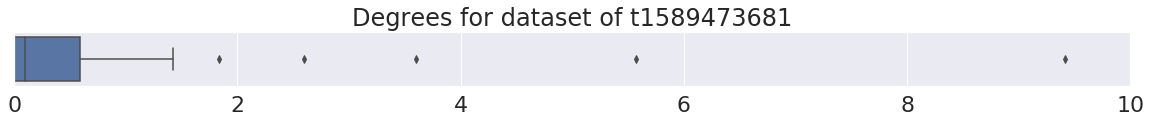

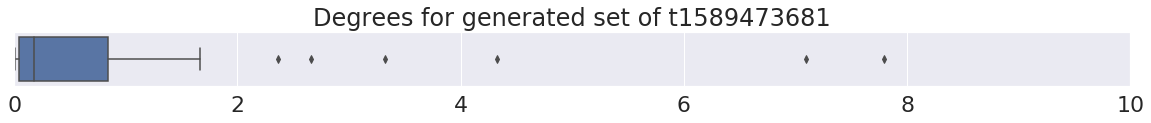

Ignored 71 graphs which are too small
Considering 129 generated graphs


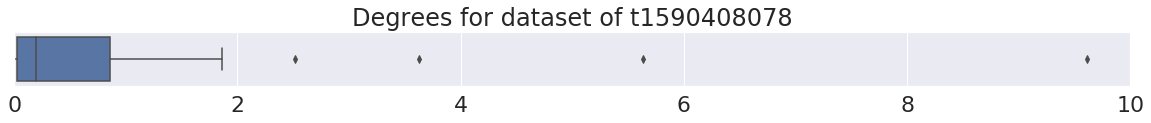

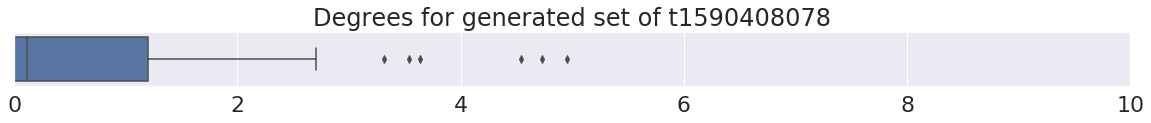

Ignored 67 graphs which are too small
Considering 133 generated graphs


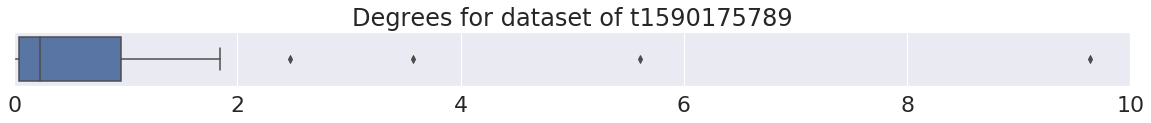

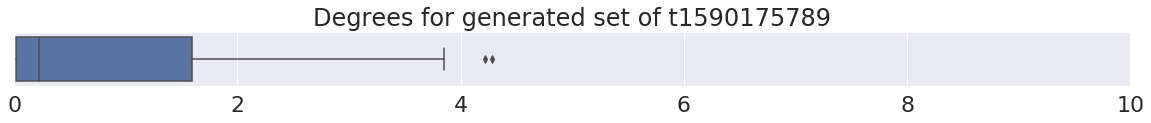

In [63]:
plot_degree_samples(keys_barabasi_albert)

In [88]:
def compare_degree_distribution_of(keys: list, name: str, kde_bw: float = 1.0):
    sns.set(style="whitegrid")
    sns.set(font_scale=2)

    counter_dataset = collections.Counter()
    counter_generated = collections.Counter()
    total_degrees_dataset = []
    total_degrees_generated = []
    total_num_graphs_dataset = 0
    total_num_graphs_generated = 0
    total_ignored = 0
    for key in tqdm(keys):

        graphs_dataset = [construction_sequence_to_graph(seq) for seq in C[key]['dataset_cs']]
        graphs_generated = []
        ignoring_generated_graphs = 0
        for seq in C[key]['generated_cs']:
            cur_graph = construction_sequence_to_graph(seq)
            if len(cur_graph) > 5:
                graphs_generated.append(cur_graph)
            else:
                ignoring_generated_graphs += 1

        #counted_degrees_dataset = count_graphs_degree(graphs_dataset)
        #counted_degrees_generated = count_graphs_degree(graphs_generated)
        degrees_dataset = np.concatenate([[d for n, d in graph.degree()] for graph in graphs_dataset])
        degrees_generated = np.concatenate([[d for n, d in graph.degree()] for graph in graphs_generated])

        num_graphs_dataset = len(graphs_dataset)
        num_graphs_generated = len(graphs_generated)
        total_num_graphs_dataset += num_graphs_dataset
        total_num_graphs_generated += num_graphs_generated
        total_ignored += ignoring_generated_graphs

        total_degrees_dataset.append(degrees_dataset)
        total_degrees_generated.append(degrees_generated)

    print(flush=True)
    print('Considering %s graphs in merged datasets' % total_num_graphs_dataset)
    print('Ignored %s generated graphs which are considered too small' % total_ignored)
    print('Considering %s generated graphs' % total_num_graphs_generated)

    #degrees = set([d for d in sorted(counter_generated)] + [d for d in sorted(counter_dataset)])
    #sorted_degrees = sorted(degrees)
    #hist_list_dataset = np.array([counter_dataset.get(d) if counter_dataset.get(d) is not None else 0 for d in sorted_degrees])
    #hist_list_generated = np.array([counter_generated.get(d) if counter_generated.get(d) is not None else 0 for d in sorted_degrees])

    print(total_degrees_dataset[:5])
    print(total_degrees_generated[:5])
    
    plt.figure(figsize=(20, 8))
    ax = sns.distplot(np.concatenate(total_degrees_dataset), bins=15, kde=False, rug=False)
    #ax = sns.swarmplot(hist_list_dataset/total_num_graphs_dataset, color=".25")
    ax.set_title('Degrees for dataset of {name}'.format(name=name))
    ax.set(xlim=(0, 15))
    plt.show()

    plt.figure(figsize=(20, 8))
    ax = sns.distplot(np.concatenate(total_degrees_generated), bins=15, kde=False, rug=False)
    #ax = sns.swarmplot(hist_list_generated/total_num_graphs_generated, color=".25")
    ax.set_title('Degrees for generated set of {name}'.format(name=name))
    ax.set(xlim=(0, 15))
    plt.show()
    
    plt.figure(figsize=(20, 8))
    ax = sns.kdeplot(np.concatenate(total_degrees_dataset), bw=kde_bw, label="dataset")
    ax = sns.kdeplot(np.concatenate(total_degrees_generated), bw=kde_bw, label="generated")
    ax.set_title('KDE for degree distributions of {name}'.format(name=name))
    ax.set(xlim=(0, 15))
    plt.legend()
    plt.show()

100%|██████████| 39/39 [00:23<00:00,  1.69it/s]

Considering 39000 graphs in merged datasets
Ignored 2670 generated graphs which are considered too small
Considering 5130 generated graphs
[array([ 9, 10, 10, ...,  9, 10,  9]), array([ 5,  5, 10, ...,  5,  4,  4]), array([ 4, 20, 15, ...,  3,  3,  3]), array([10,  9,  9, ..., 10,  9, 10]), array([11,  6, 14, ...,  7,  7,  6])]
[array([7, 8, 9, ..., 2, 2, 2]), array([4, 5, 4, ..., 5, 7, 6]), array([1, 3, 7, ..., 1, 5, 3]), array([0, 3, 5, ..., 3, 6, 6]), array([10,  6,  8, ...,  2,  2,  2])]


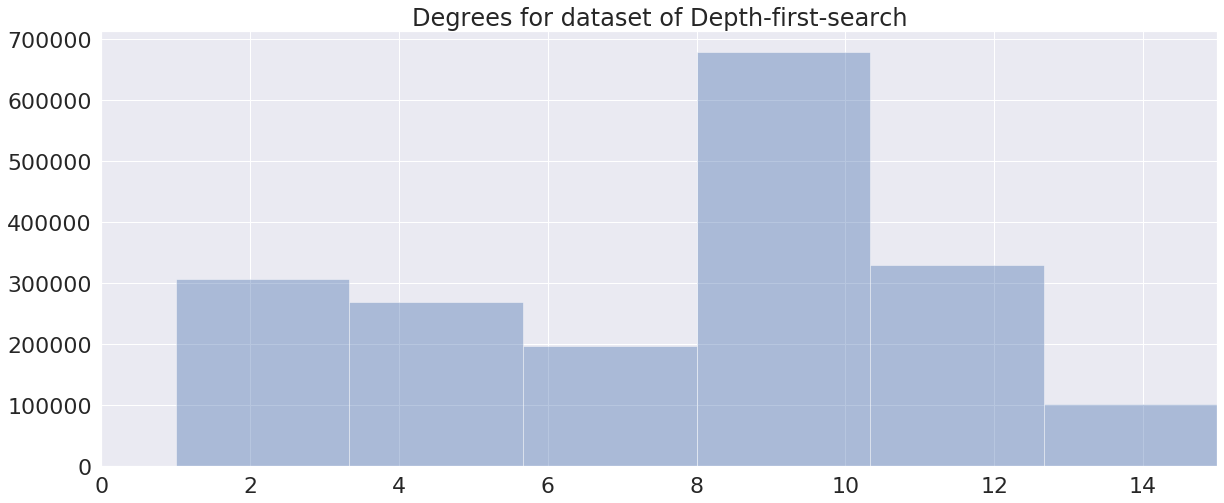

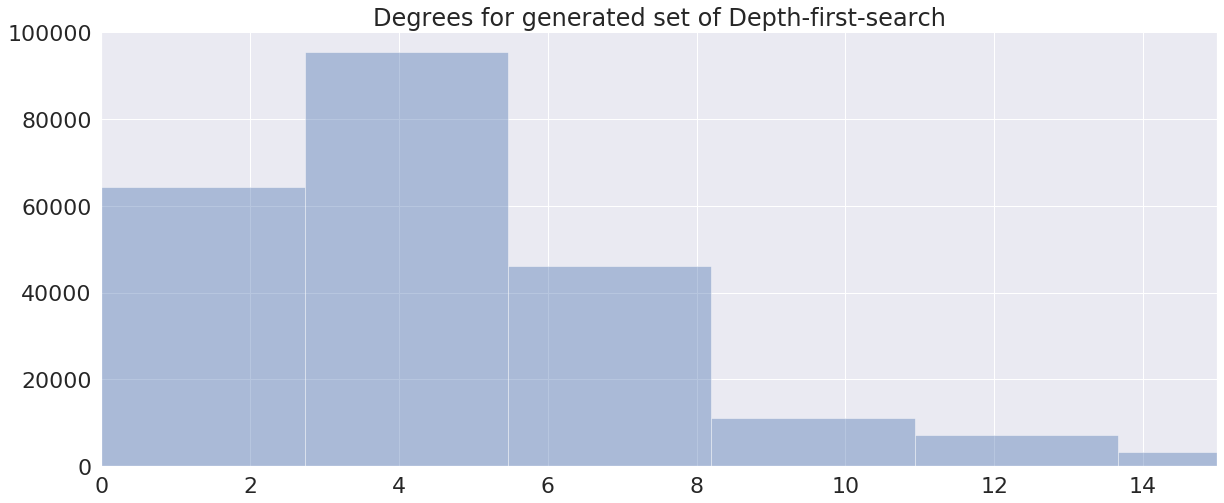

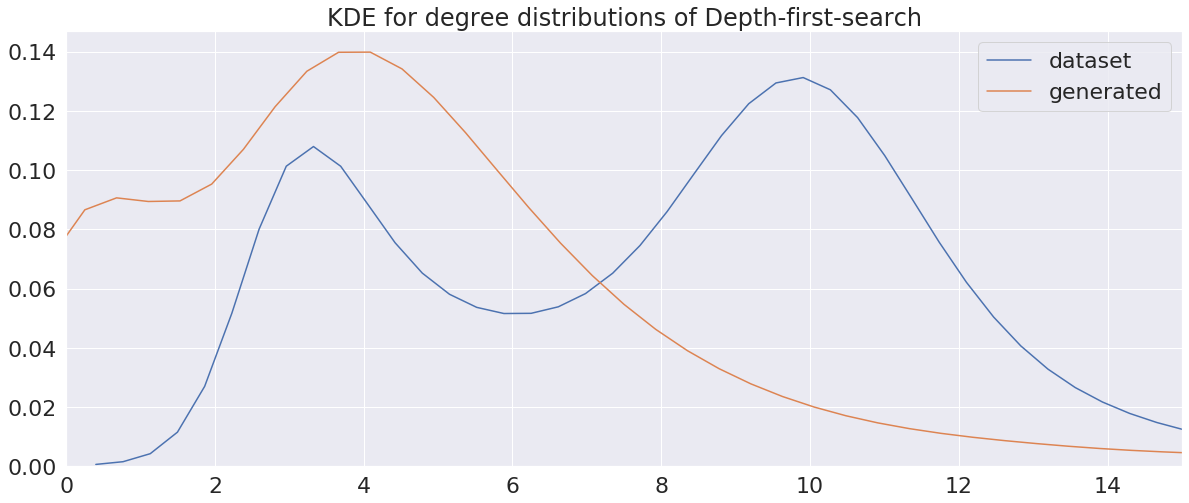

In [91]:
compare_degree_distribution_of(keys_dfs, 'Depth-first-search', 0.2)

100%|██████████| 5/5 [00:02<00:00,  2.18it/s]

Considering 5000 graphs in merged datasets
Ignored 361 generated graphs which are considered too small
Considering 639 generated graphs
[array([ 5,  5, 10, ...,  5,  4,  4]), array([ 4, 20, 15, ...,  3,  3,  3]), array([10, 16, 12, ...,  3,  3,  3]), array([11,  2, 11, ...,  3,  3,  3]), array([15, 13,  6, ...,  3,  3,  4])]
[array([4, 5, 4, ..., 5, 7, 6]), array([1, 3, 7, ..., 1, 5, 3]), array([10,  7,  8, ...,  3,  2,  0]), array([4, 1, 4, ..., 1, 0, 0]), array([2, 5, 4, ..., 3, 5, 2])]


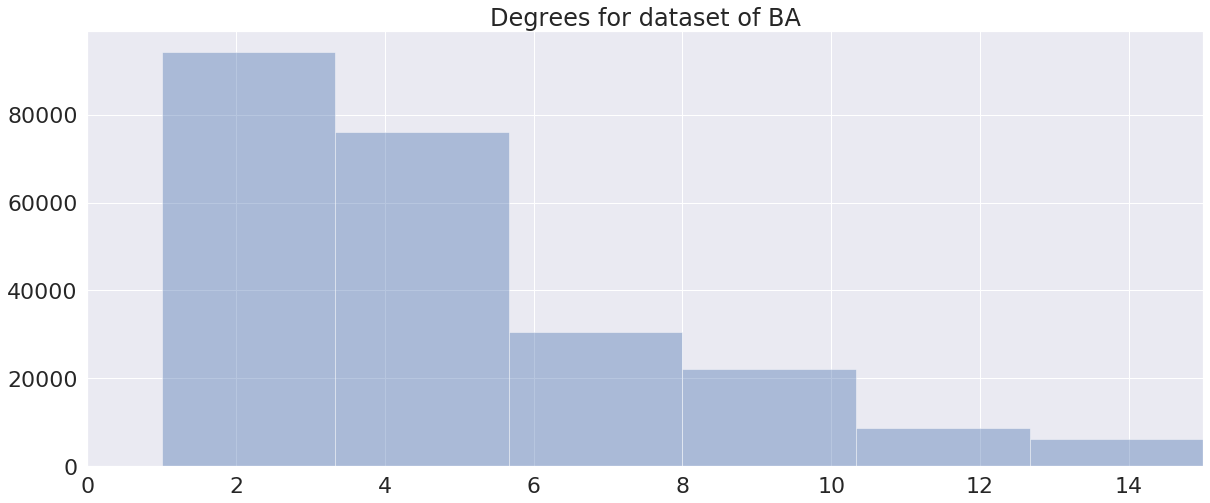

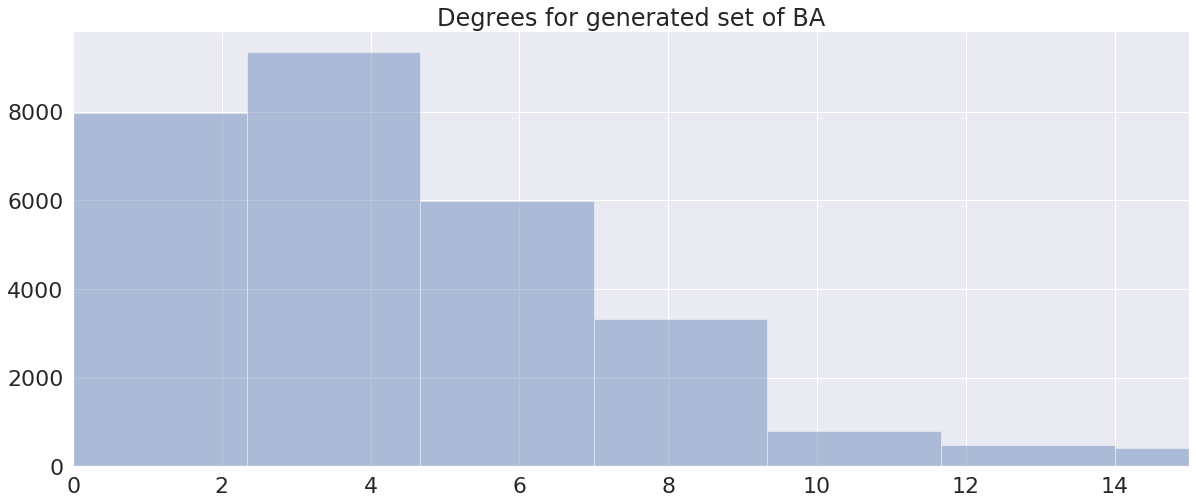

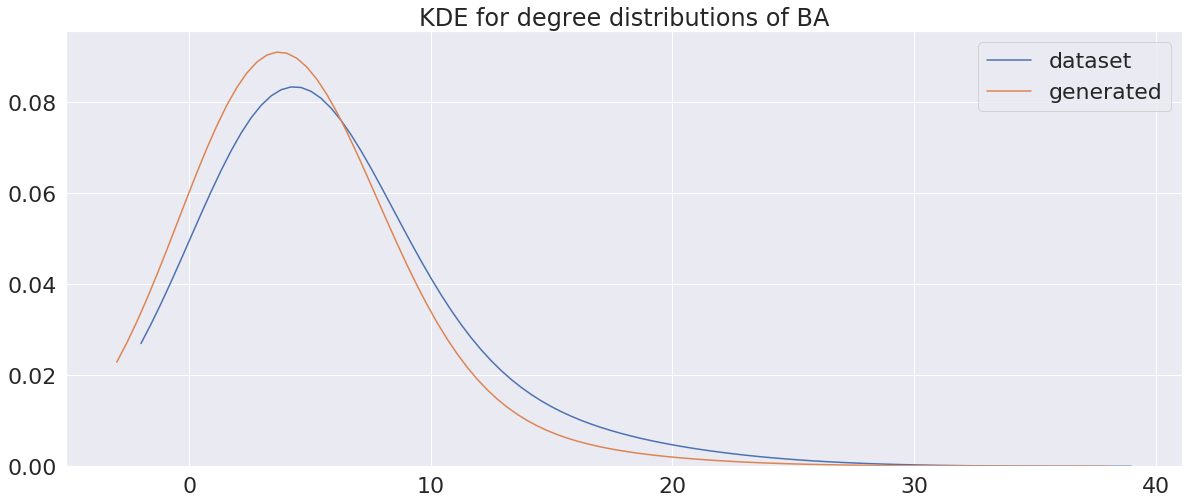

In [85]:
compare_degree_distribution_of(keys_barabasi_albert[:5], 'BA')

100%|██████████| 39/39 [00:23<00:00,  1.68it/s]

Considering 39000 graphs in merged datasets
Ignored 2670 generated graphs which are considered too small
Considering 5130 generated graphs
[array([ 9, 10, 10, ...,  9, 10,  9]), array([ 5,  5, 10, ...,  5,  4,  4]), array([ 4, 20, 15, ...,  3,  3,  3]), array([10,  9,  9, ..., 10,  9, 10]), array([11,  6, 14, ...,  7,  7,  6])]
[array([7, 8, 9, ..., 2, 2, 2]), array([4, 5, 4, ..., 5, 7, 6]), array([1, 3, 7, ..., 1, 5, 3]), array([0, 3, 5, ..., 3, 6, 6]), array([10,  6,  8, ...,  2,  2,  2])]


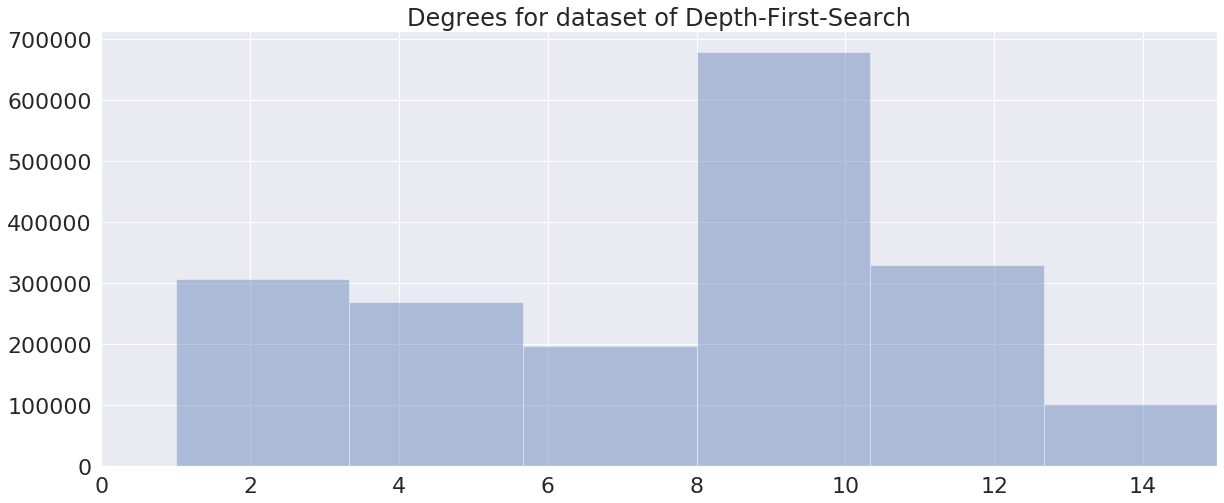

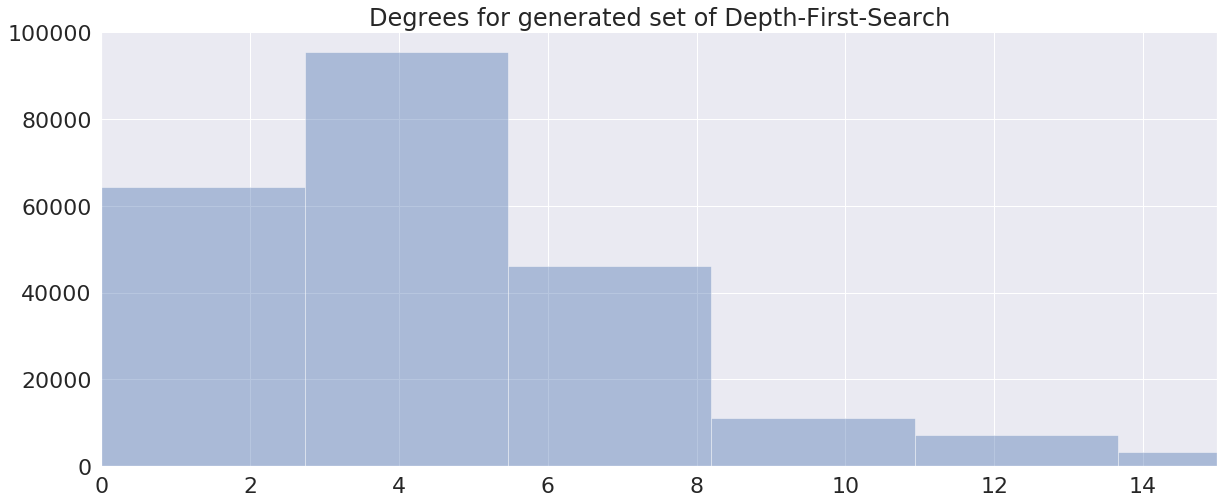

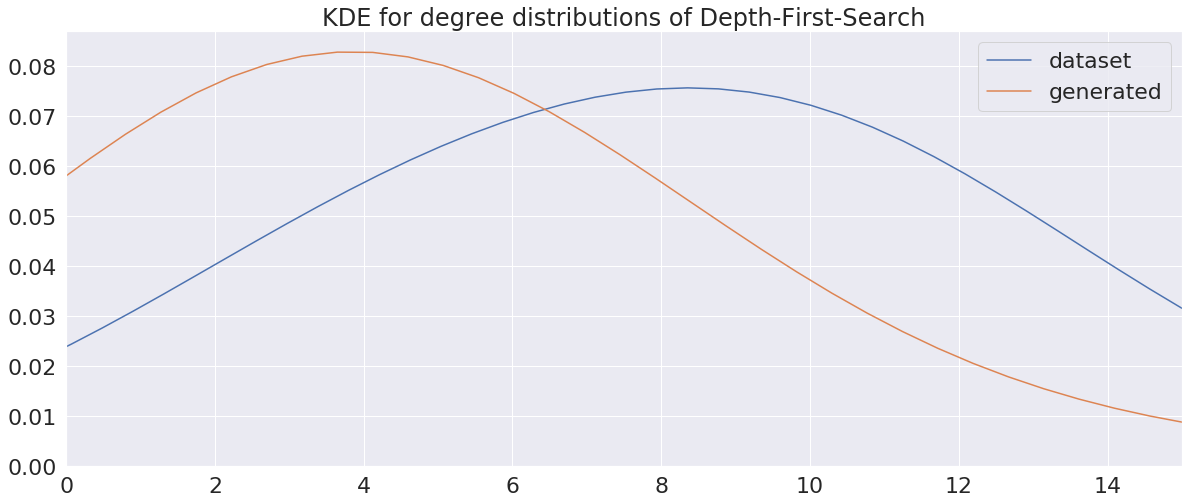

100%|██████████| 24/24 [00:15<00:00,  1.60it/s]

Considering 24000 graphs in merged datasets
Ignored 1454 generated graphs which are considered too small
Considering 3346 generated graphs
[array([10,  8, 10, ...,  9,  7,  9]), array([11, 11, 11, ..., 12, 10, 10]), array([ 7,  6, 11, ...,  6,  3,  8]), array([ 9, 13,  9, ...,  6, 10,  8]), array([19, 12,  8, ...,  8,  5,  4])]
[array([ 6,  7,  6, ...,  6, 10,  9]), array([10, 14,  7, ...,  2,  3,  0]), array([15, 25, 15, ...,  1,  0,  0]), array([10, 14,  2, ...,  1,  2,  1]), array([9, 3, 3, ..., 0, 1, 0])]


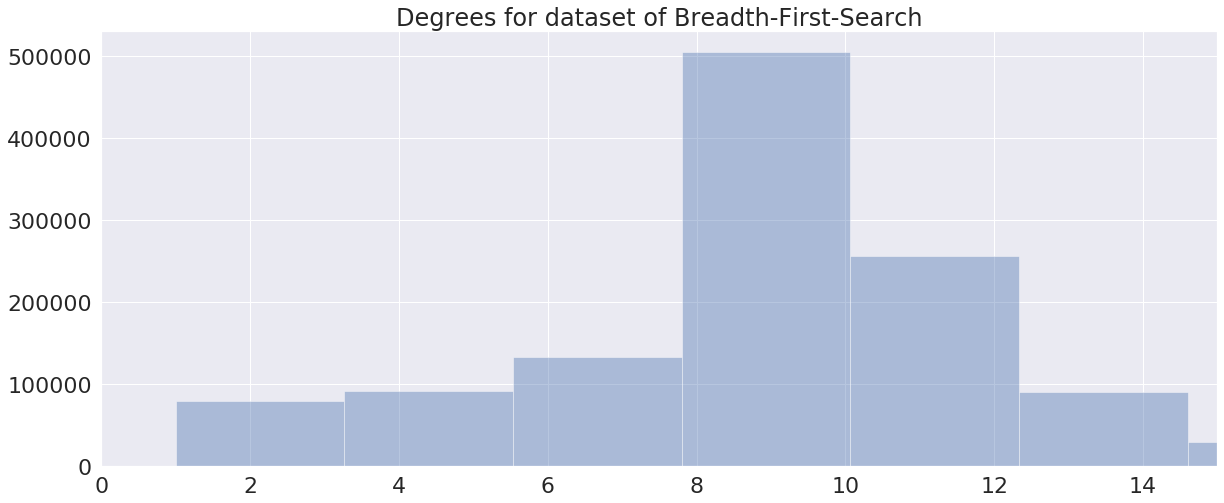

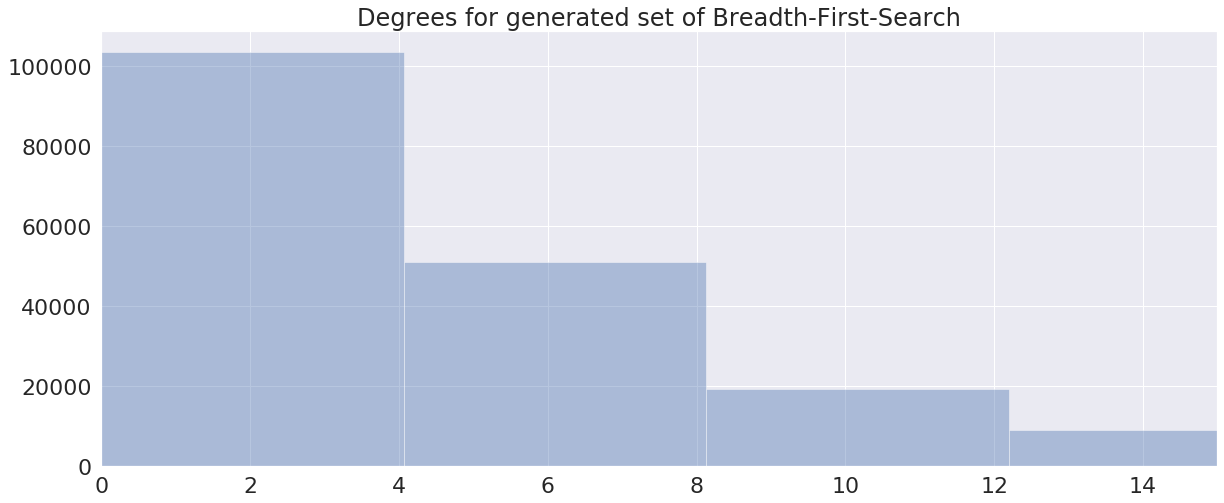

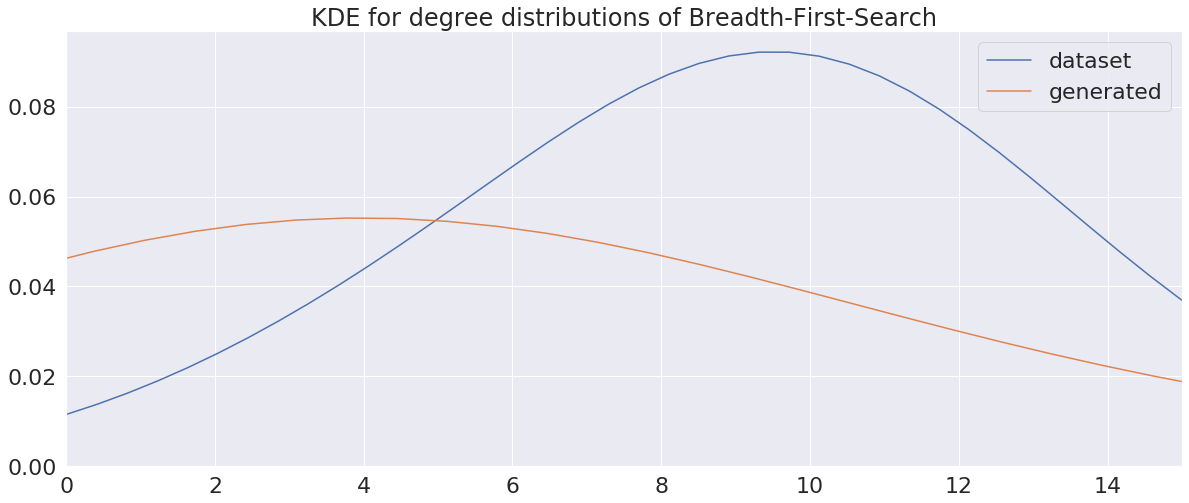

100%|██████████| 6/6 [00:02<00:00,  2.18it/s]

Considering 6000 graphs in merged datasets
Ignored 345 generated graphs which are considered too small
Considering 855 generated graphs
[array([10, 16, 12, ...,  3,  3,  3]), array([11,  2, 11, ...,  3,  3,  3]), array([ 5, 13, 14, ...,  3,  3,  3]), array([13, 20,  4, ...,  3,  3,  3]), array([ 5,  1, 16, ...,  3,  3,  3])]
[array([10,  7,  8, ...,  3,  2,  0]), array([4, 1, 4, ..., 1, 0, 0]), array([9, 8, 7, ..., 2, 2, 0]), array([7, 6, 3, ..., 3, 1, 0]), array([ 9,  5, 14, ...,  2,  2,  0])]


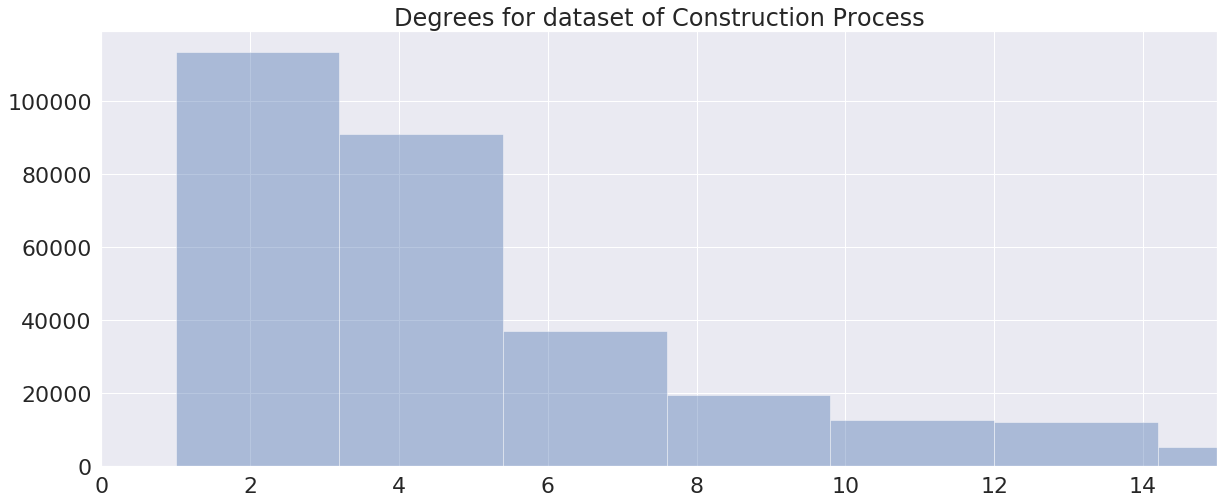

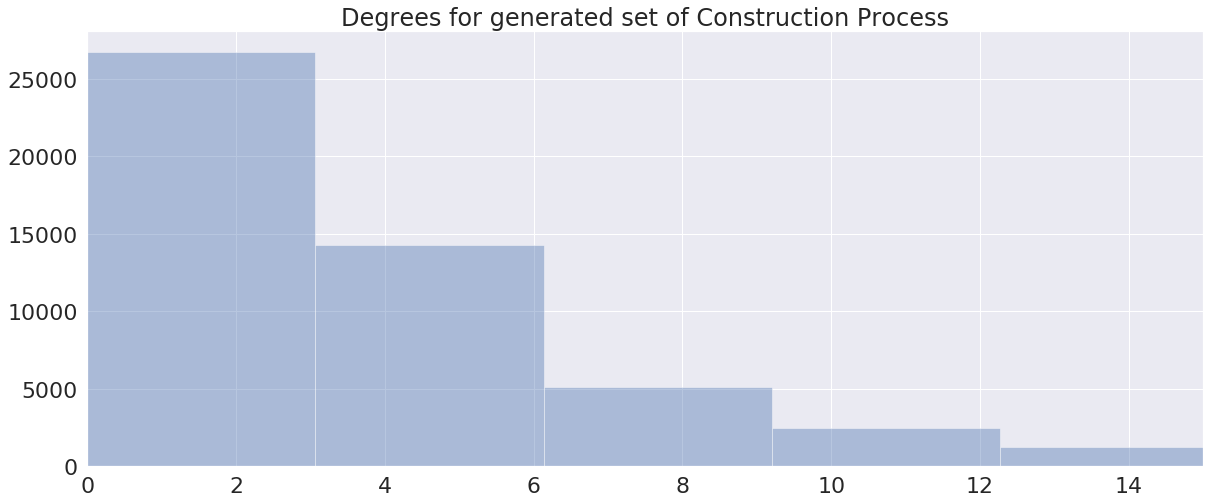

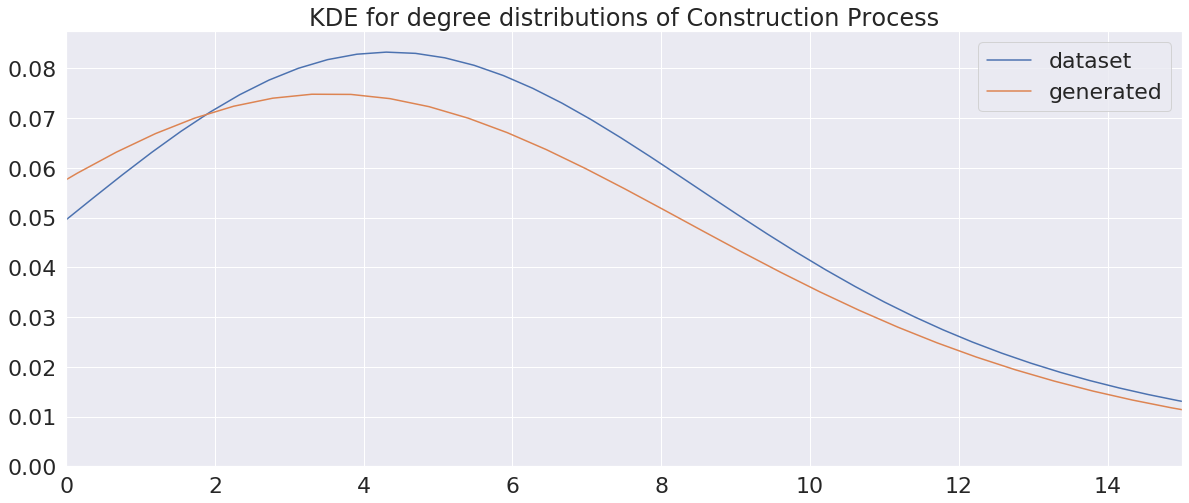

100%|██████████| 24/24 [00:15<00:00,  1.59it/s]

Considering 24000 graphs in merged datasets
Ignored 1649 generated graphs which are considered too small
Considering 3151 generated graphs
[array([ 7,  6, 11, ...,  6,  3,  8]), array([ 9, 13,  9, ...,  6, 10,  8]), array([19, 12,  8, ...,  8,  5,  4]), array([11,  6, 14, ...,  7,  7,  6]), array([15, 13,  7, ...,  6,  7,  7])]
[array([15, 25, 15, ...,  1,  0,  0]), array([10, 14,  2, ...,  1,  2,  1]), array([9, 3, 3, ..., 0, 1, 0]), array([10,  6,  8, ...,  2,  2,  2]), array([9, 7, 8, ..., 7, 6, 1])]


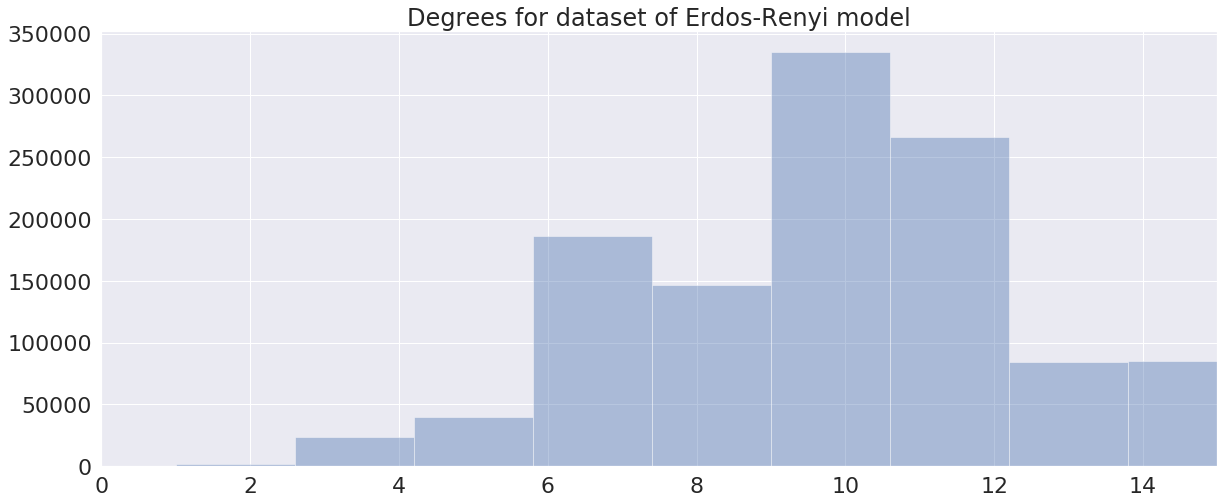

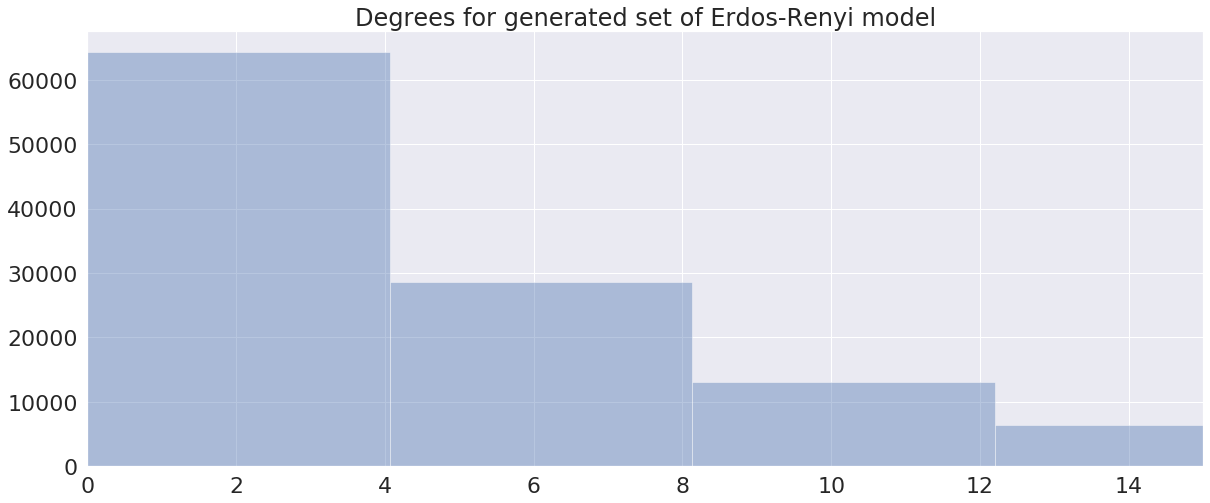

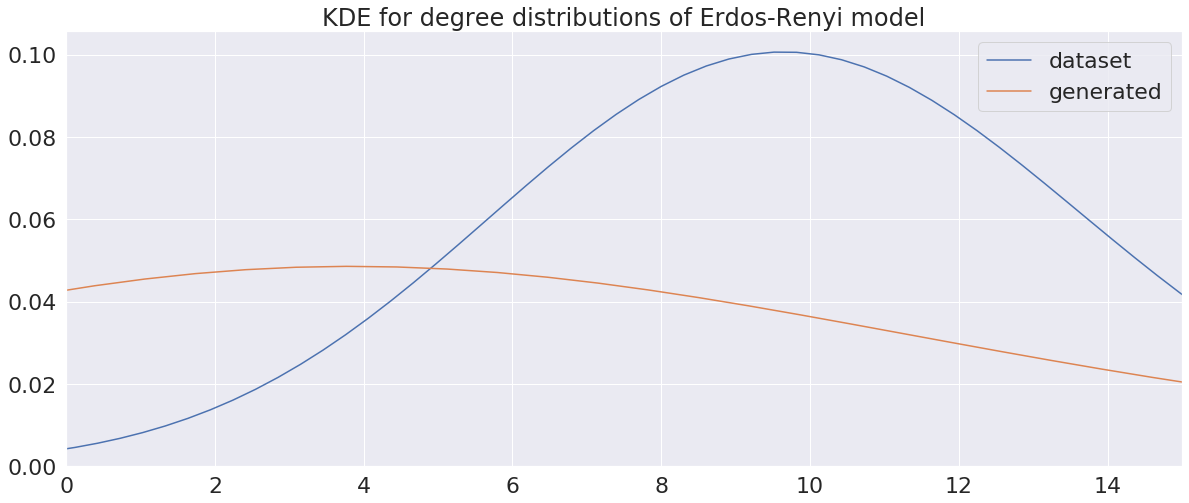

100%|██████████| 26/26 [00:13<00:00,  1.91it/s]

Considering 26000 graphs in merged datasets
Ignored 1624 generated graphs which are considered too small
Considering 3576 generated graphs
[array([ 5,  5, 10, ...,  5,  4,  4]), array([ 4, 20, 15, ...,  3,  3,  3]), array([10, 16, 12, ...,  3,  3,  3]), array([11,  2, 11, ...,  3,  3,  3]), array([15, 13,  6, ...,  3,  3,  4])]
[array([4, 5, 4, ..., 5, 7, 6]), array([1, 3, 7, ..., 1, 5, 3]), array([10,  7,  8, ...,  3,  2,  0]), array([4, 1, 4, ..., 1, 0, 0]), array([2, 5, 4, ..., 3, 5, 2])]


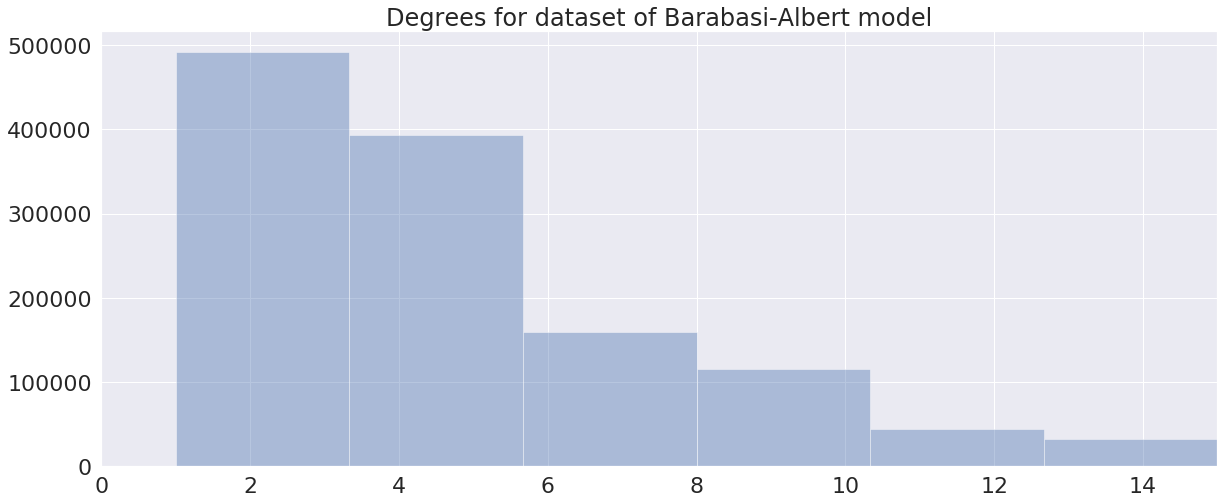

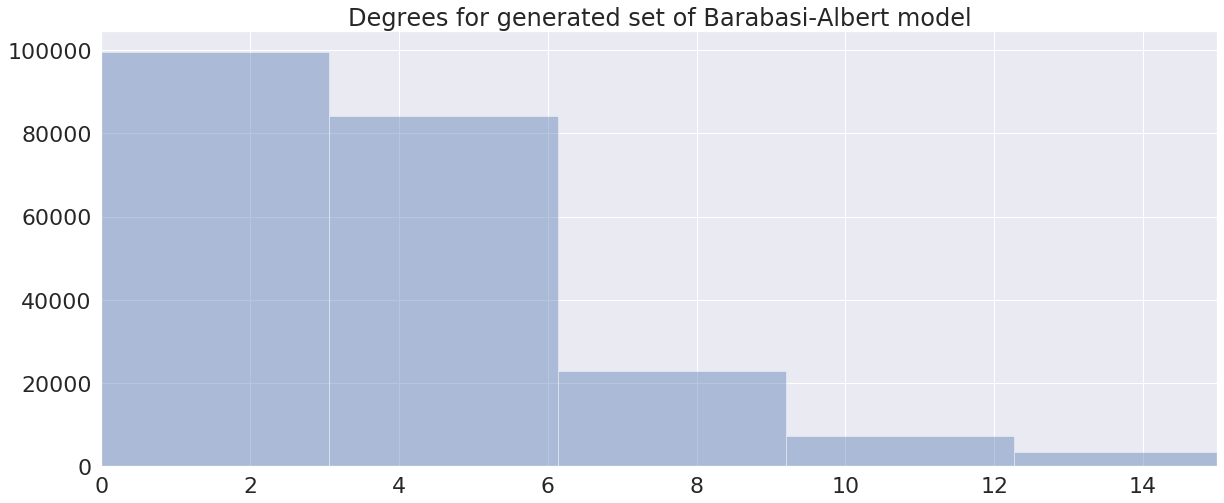

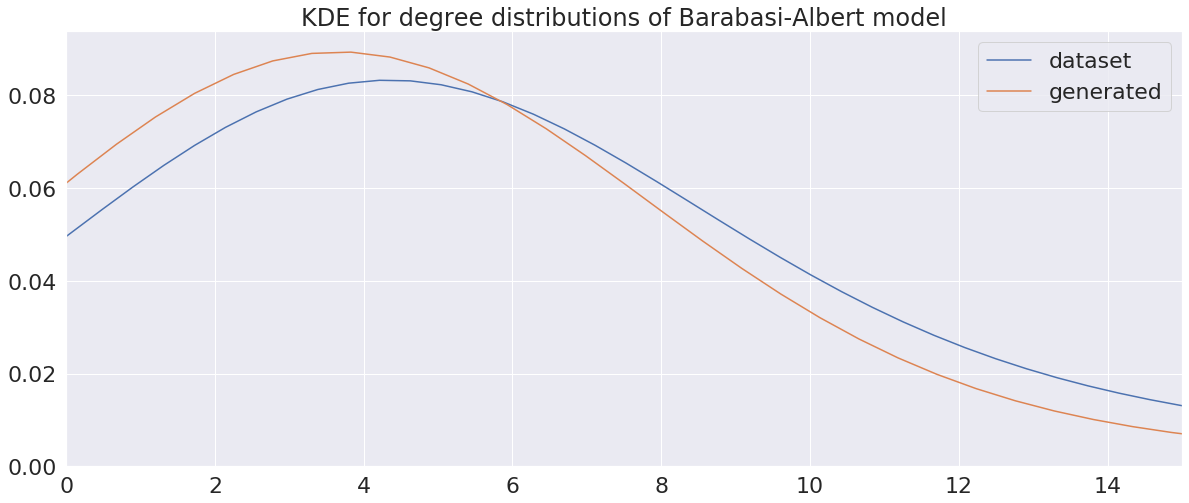

100%|██████████| 19/19 [00:12<00:00,  1.55it/s]

Considering 19000 graphs in merged datasets
Ignored 1196 generated graphs which are considered too small
Considering 2604 generated graphs
[array([ 9, 10, 10, ...,  9, 10,  9]), array([10,  8, 10, ...,  9,  7,  9]), array([11, 11, 11, ..., 12, 10, 10]), array([10,  9,  9, ..., 10,  9, 10]), array([14,  9, 10, ..., 10,  9, 10])]
[array([7, 8, 9, ..., 2, 2, 2]), array([ 6,  7,  6, ...,  6, 10,  9]), array([10, 14,  7, ...,  2,  3,  0]), array([0, 3, 5, ..., 3, 6, 6]), array([21, 29, 16, ...,  2,  1,  2])]


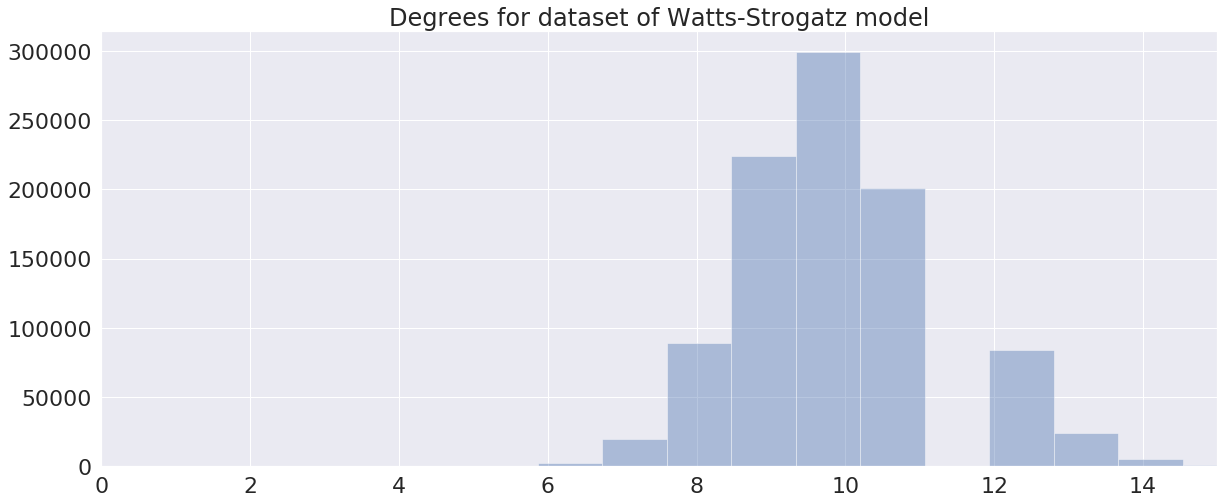

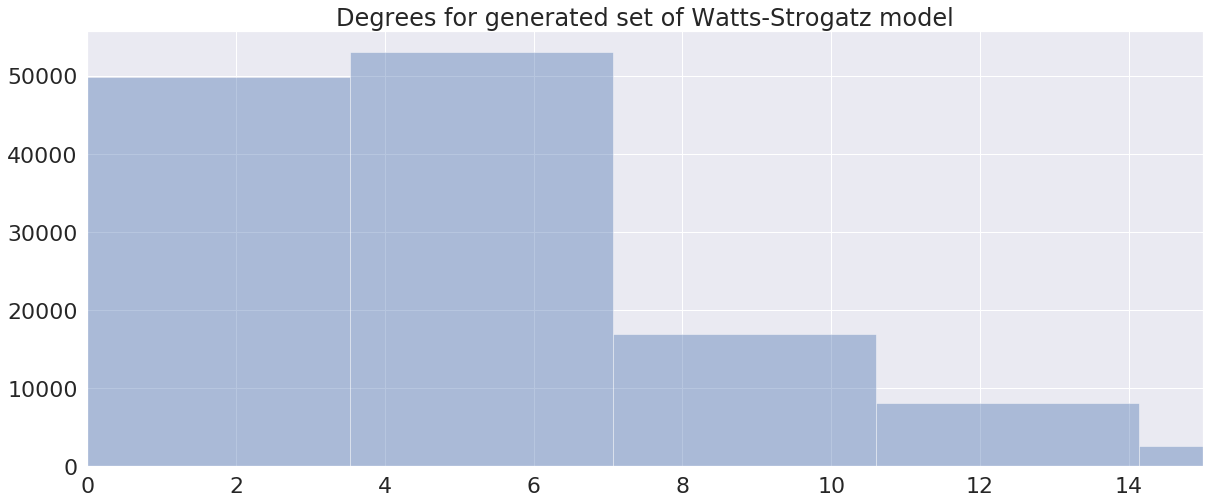

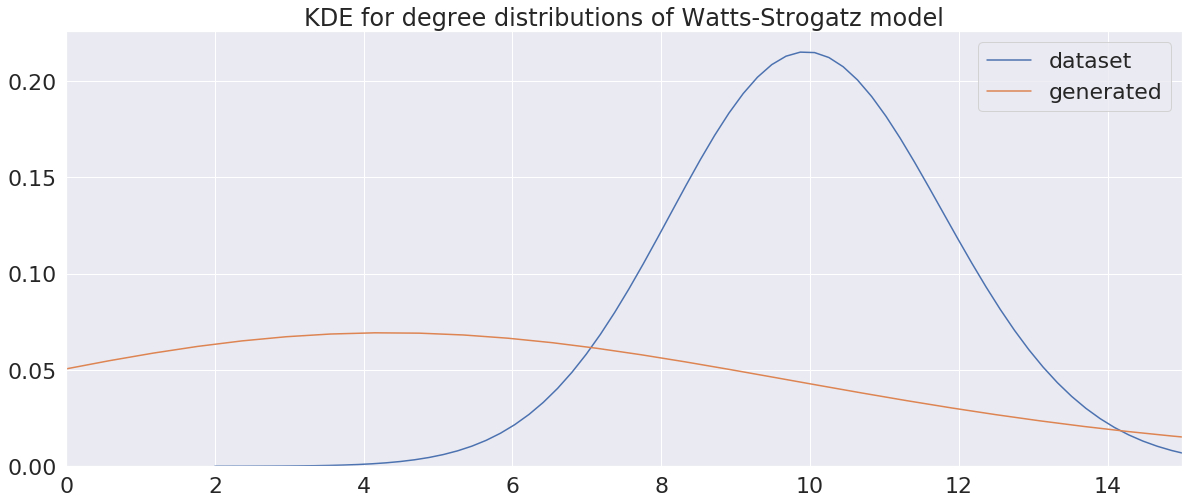

100%|██████████| 13/13 [00:08<00:00,  1.54it/s]

Considering 13000 graphs in merged datasets
Ignored 842 generated graphs which are considered too small
Considering 1758 generated graphs
[array([ 7,  6, 11, ...,  6,  3,  8]), array([ 9, 13,  9, ...,  6, 10,  8]), array([19, 12,  8, ...,  8,  5,  4]), array([13, 14, 10, ...,  7,  7,  9]), array([11,  8, 16, ..., 10,  7,  5])]
[array([15, 25, 15, ...,  1,  0,  0]), array([10, 14,  2, ...,  1,  2,  1]), array([9, 3, 3, ..., 0, 1, 0]), array([ 2, 11, 13, ...,  0,  0,  0]), array([12, 12, 14, ...,  0,  0,  0])]


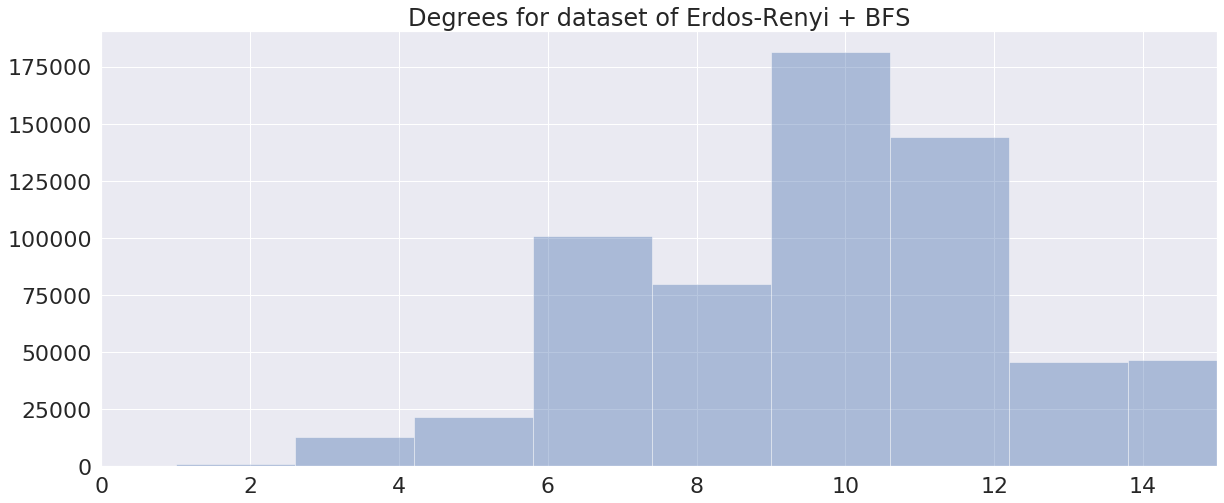

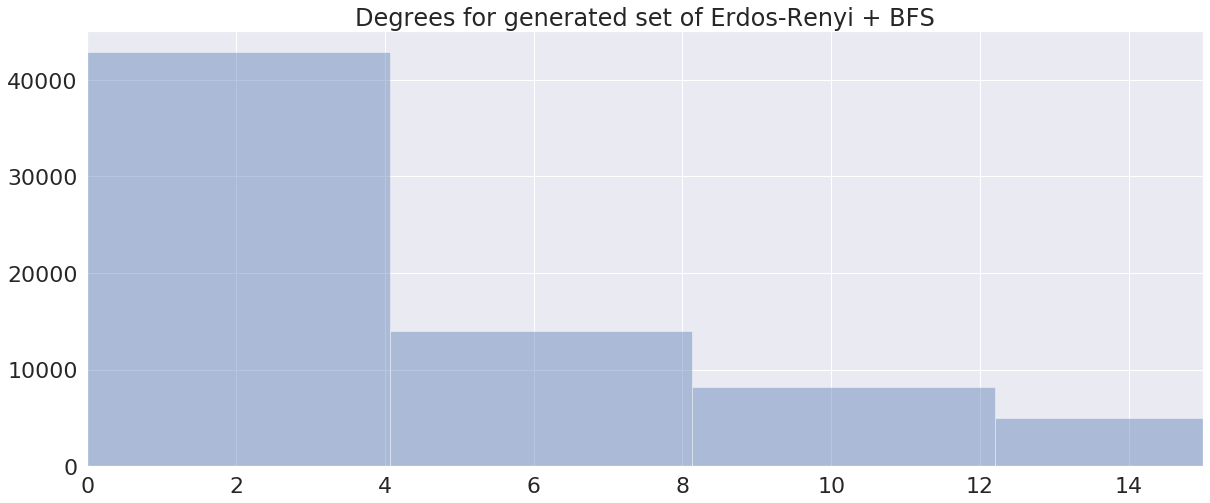

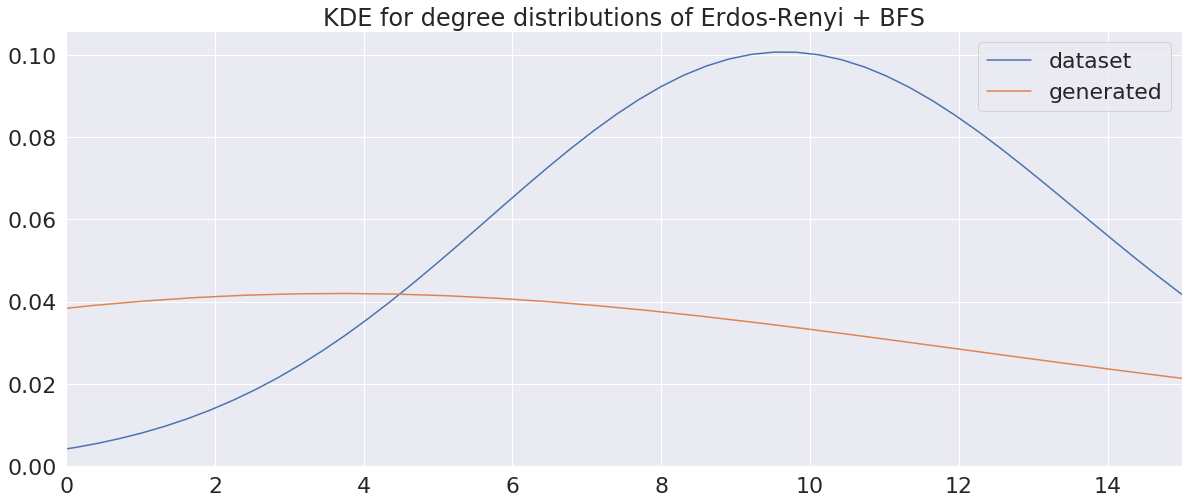

100%|██████████| 11/11 [00:06<00:00,  1.65it/s]

Considering 11000 graphs in merged datasets
Ignored 807 generated graphs which are considered too small
Considering 1393 generated graphs
[array([11,  6, 14, ...,  7,  7,  6]), array([15, 13,  7, ...,  6,  7,  7]), array([11, 13, 14, ...,  5,  8,  5]), array([ 5,  9,  7, ...,  6, 14,  8]), array([10,  8,  6, ...,  7, 10,  6])]
[array([10,  6,  8, ...,  2,  2,  2]), array([9, 7, 8, ..., 7, 6, 1]), array([ 3,  4,  3, ..., 10,  8, 11]), array([ 4,  7,  7, ...,  9,  5, 10]), array([0, 6, 5, ..., 0, 0, 0])]


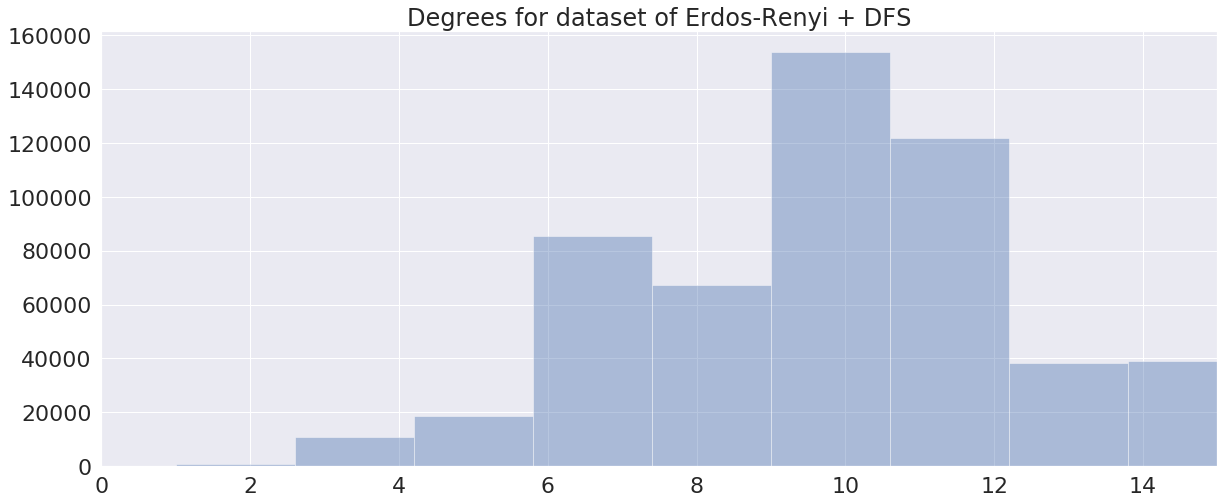

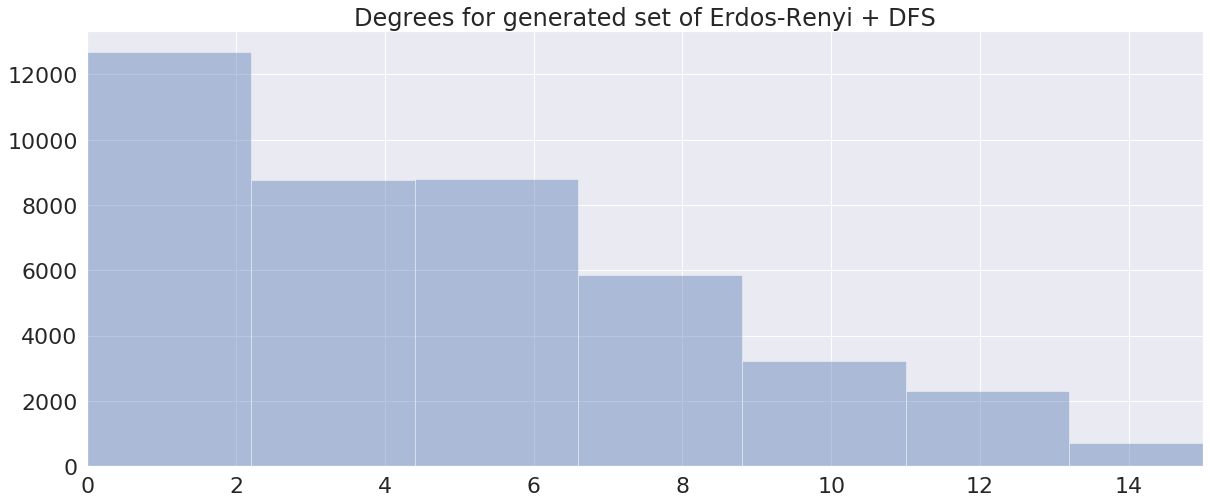

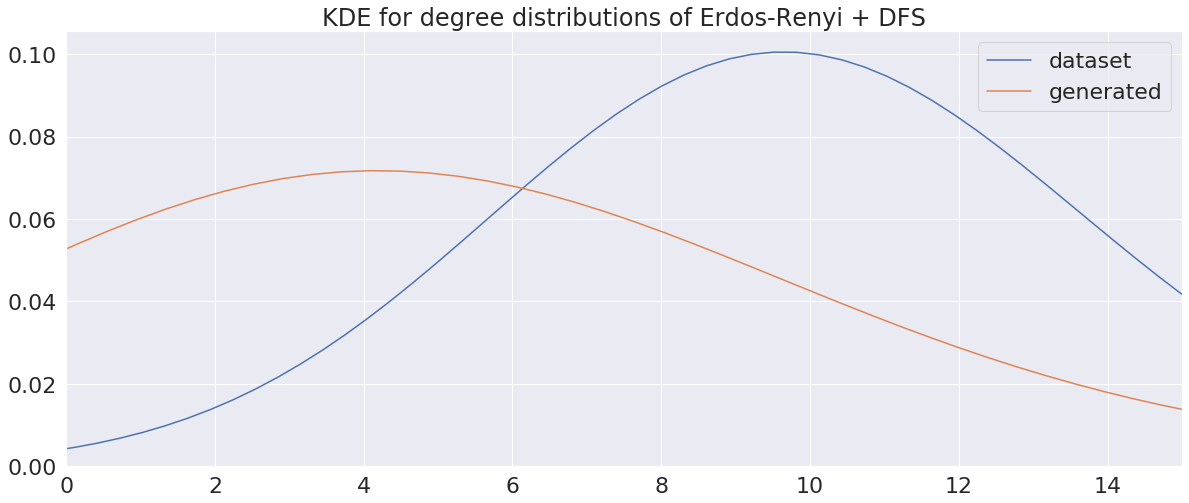

100%|██████████| 4/4 [00:02<00:00,  1.65it/s]

Considering 4000 graphs in merged datasets
Ignored 211 generated graphs which are considered too small
Considering 589 generated graphs
[array([ 9, 10, 18, ...,  4,  3,  3]), array([ 5, 20, 19, ...,  3,  3,  3]), array([ 6, 18,  9, ...,  3,  3,  3]), array([ 5, 24,  8, ...,  3,  3,  4])]
[array([ 9, 14, 19, ...,  0,  1,  0]), array([9, 6, 3, ..., 0, 0, 0]), array([2, 4, 7, ..., 4, 4, 4]), array([4, 3, 3, ..., 3, 3, 1])]


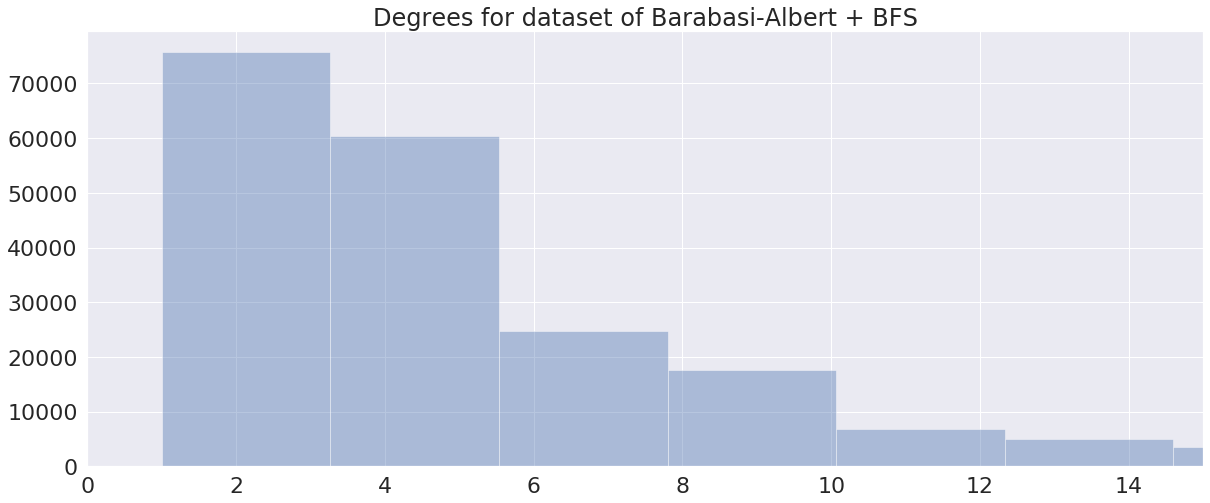

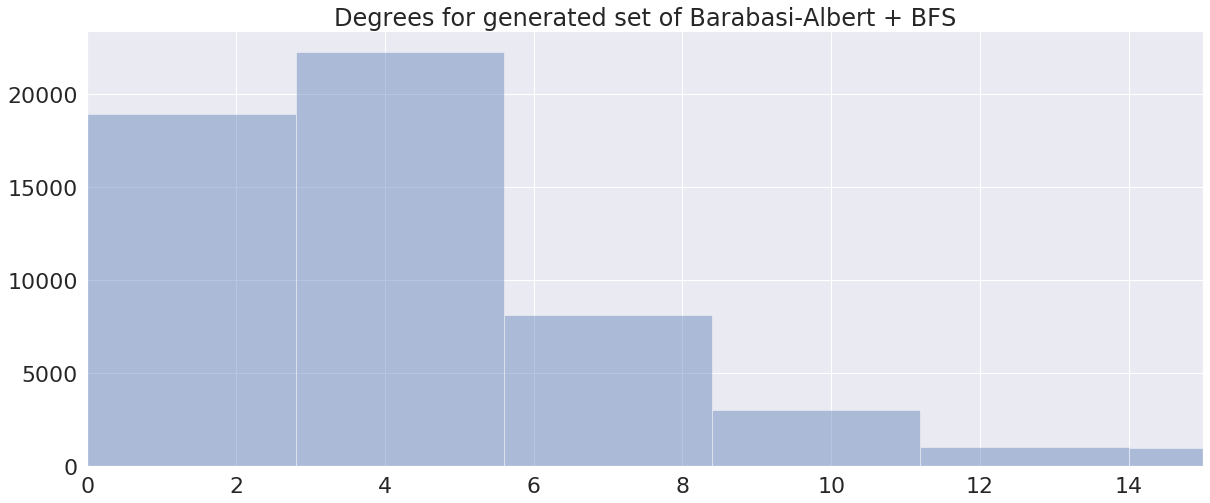

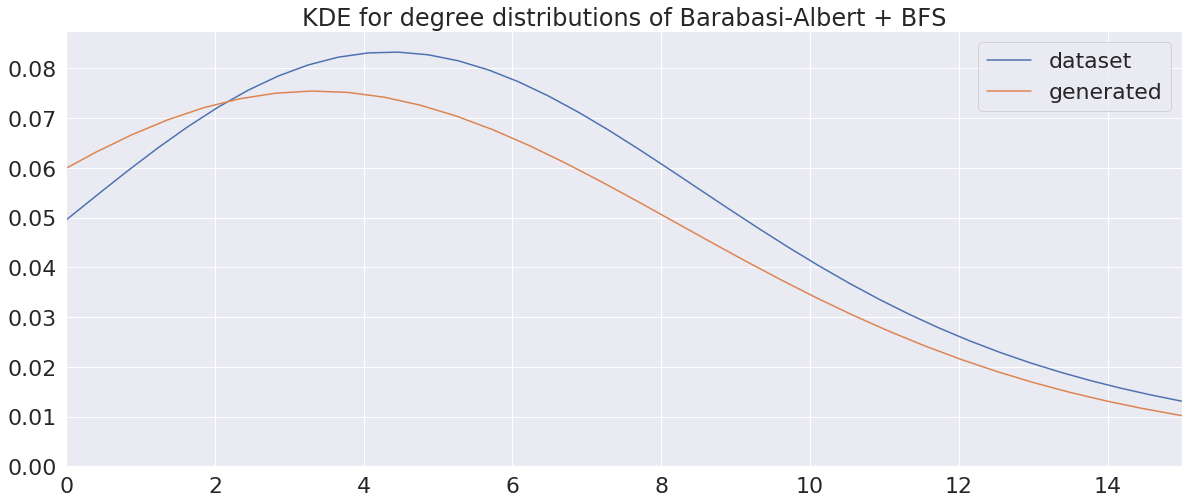

100%|██████████| 16/16 [00:08<00:00,  1.92it/s]

Considering 16000 graphs in merged datasets
Ignored 1068 generated graphs which are considered too small
Considering 2132 generated graphs
[array([ 5,  5, 10, ...,  5,  4,  4]), array([ 4, 20, 15, ...,  3,  3,  3]), array([15, 13,  6, ...,  3,  3,  4]), array([ 3, 21, 17, ...,  6,  3,  3]), array([ 3, 13, 22, ...,  3,  3,  3])]
[array([4, 5, 4, ..., 5, 7, 6]), array([1, 3, 7, ..., 1, 5, 3]), array([2, 5, 4, ..., 3, 5, 2]), array([6, 7, 7, ..., 0, 0, 0]), array([2, 5, 6, ..., 2, 4, 4])]


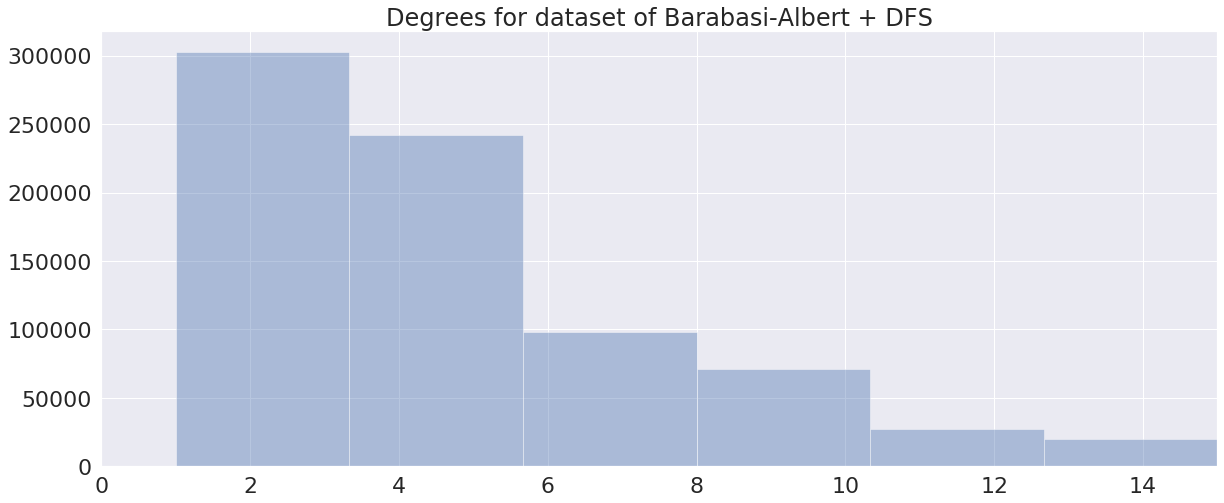

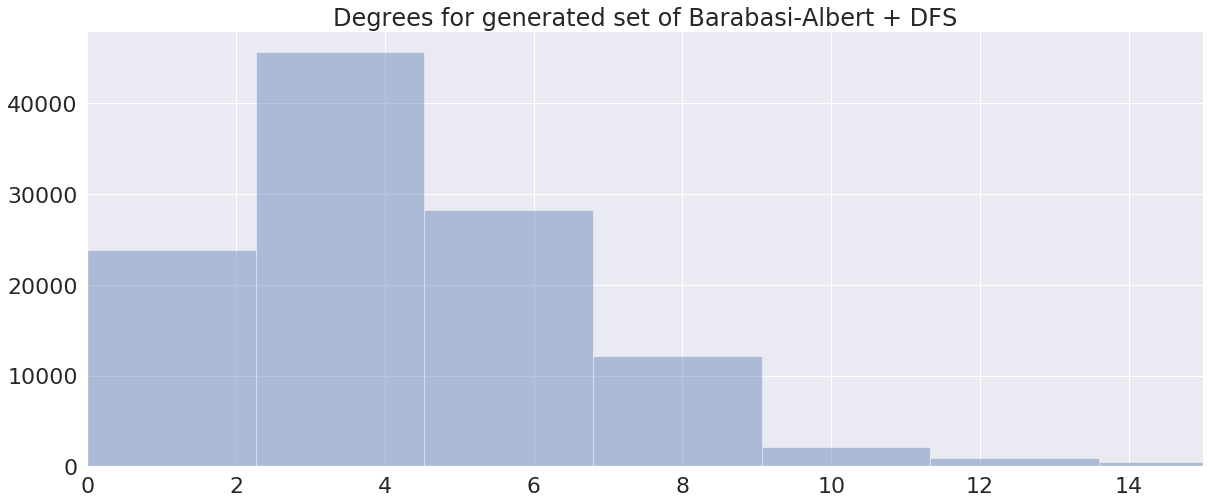

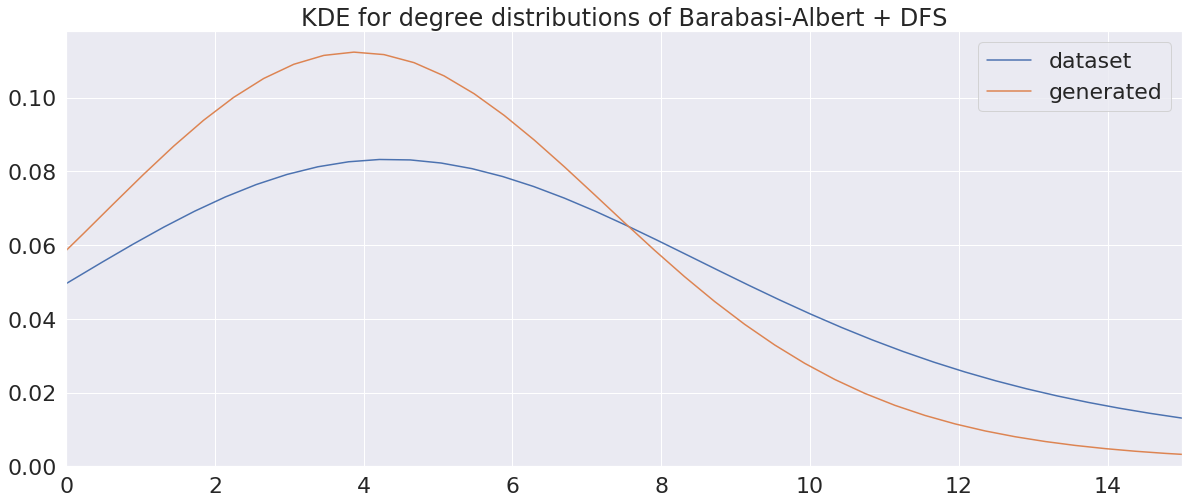

100%|██████████| 7/7 [00:04<00:00,  1.50it/s]

Considering 7000 graphs in merged datasets
Ignored 401 generated graphs which are considered too small
Considering 999 generated graphs
[array([10,  8, 10, ...,  9,  7,  9]), array([11, 11, 11, ..., 12, 10, 10]), array([ 6, 10, 10, ..., 10,  9, 11]), array([12,  9,  9, ..., 10, 10, 10]), array([10, 10, 10, ...,  8,  9,  9])]
[array([ 6,  7,  6, ...,  6, 10,  9]), array([10, 14,  7, ...,  2,  3,  0]), array([ 7,  2,  6, ..., 13,  9, 19]), array([4, 4, 6, ..., 1, 3, 0]), array([4, 7, 3, ..., 6, 7, 4])]


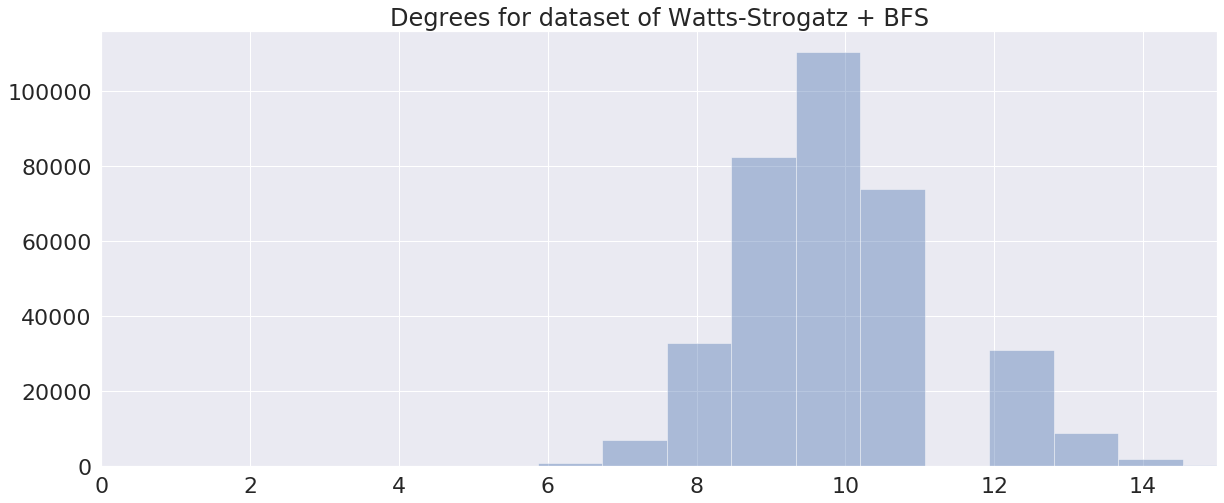

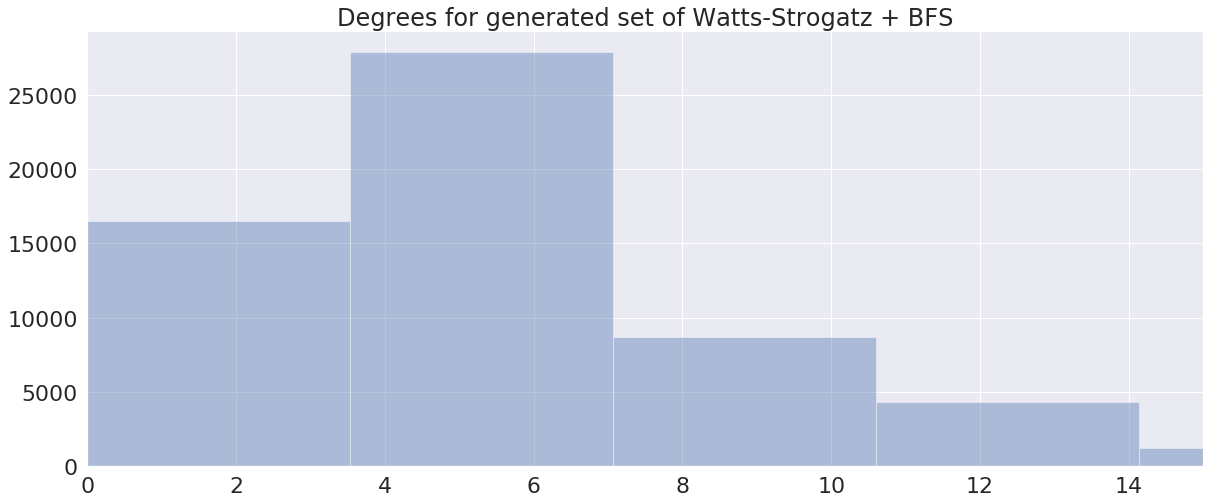

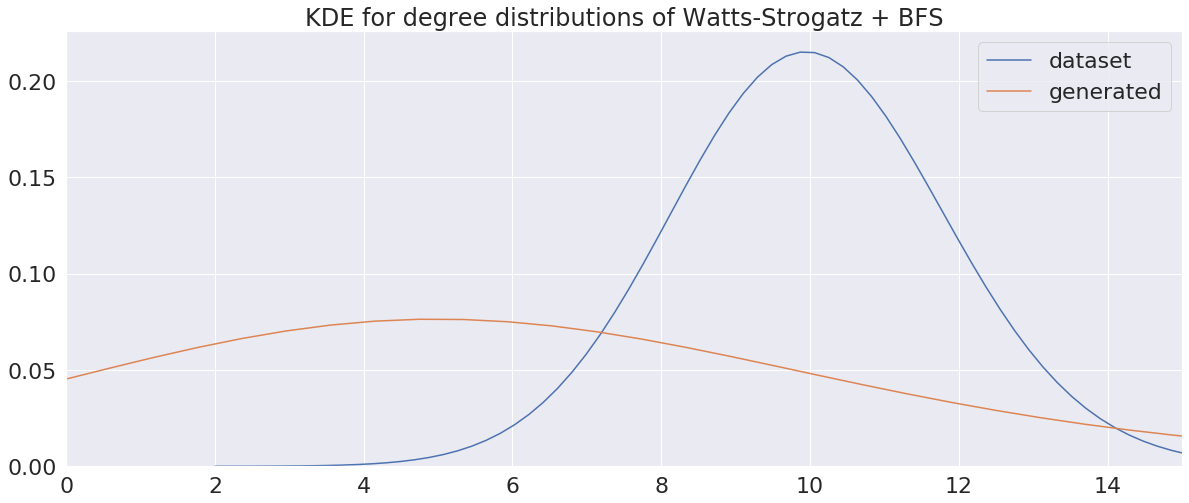

100%|██████████| 12/12 [00:07<00:00,  1.55it/s]

Considering 12000 graphs in merged datasets
Ignored 795 generated graphs which are considered too small
Considering 1605 generated graphs
[array([ 9, 10, 10, ...,  9, 10,  9]), array([10,  9,  9, ..., 10,  9, 10]), array([14,  9, 10, ..., 10,  9, 10]), array([10, 13, 10, ...,  9, 11,  8]), array([ 9, 11, 11, ..., 10, 10,  9])]
[array([7, 8, 9, ..., 2, 2, 2]), array([0, 3, 5, ..., 3, 6, 6]), array([21, 29, 16, ...,  2,  1,  2]), array([ 9, 15,  4, ...,  0,  0,  0]), array([ 4,  5,  7, ...,  9, 10, 13])]


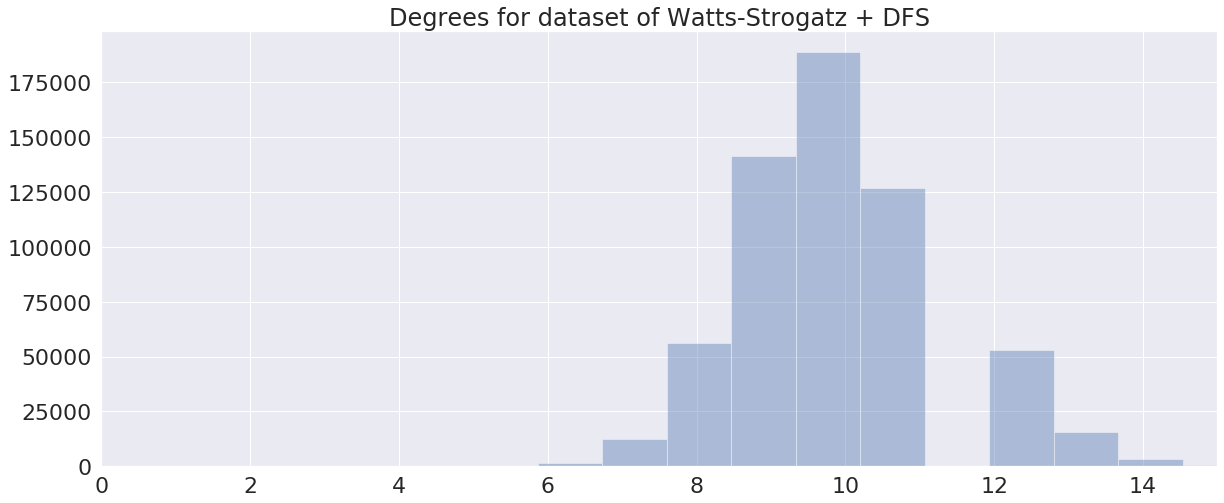

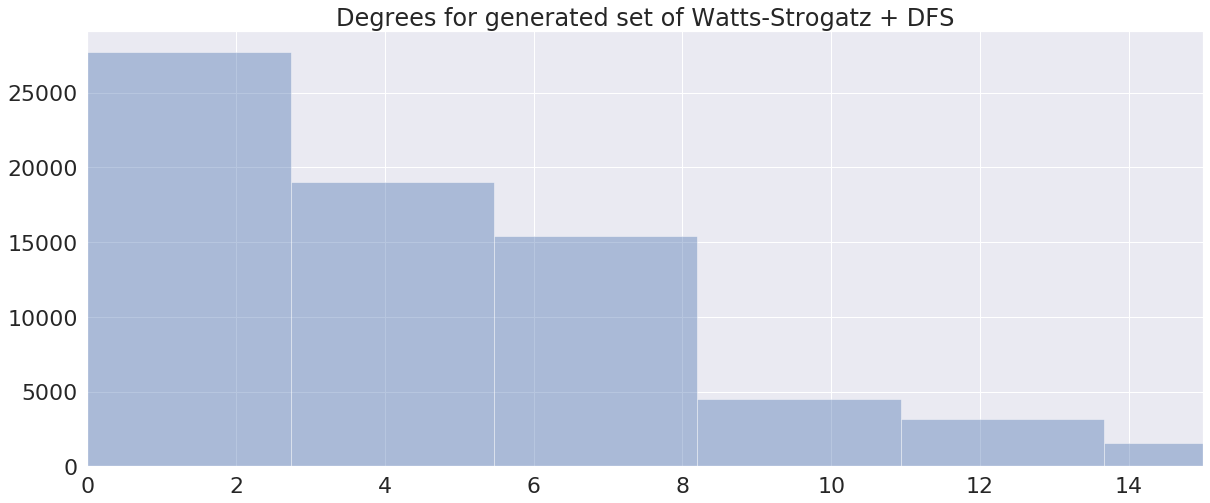

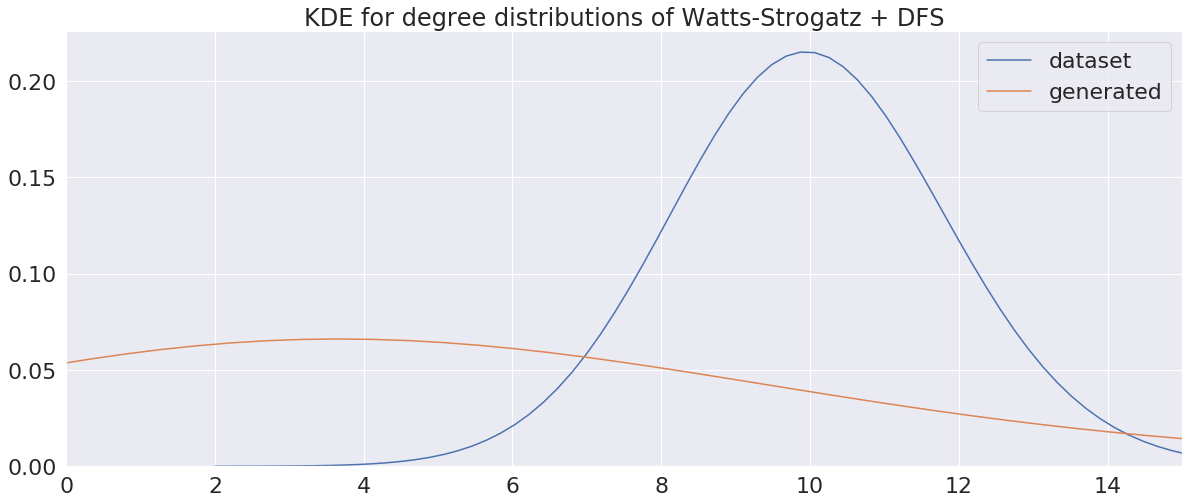

In [90]:
for subset_name in subsets:
    compare_degree_distribution_of(subsets[subset_name], subset_name)

100%|██████████| 39/39 [00:22<00:00,  1.73it/s]

Considering 39000 graphs in merged datasets
Ignored 2670 generated graphs which are considered too small
Considering 5130 generated graphs
[array([ 9, 10, 10, ...,  9, 10,  9]), array([ 5,  5, 10, ...,  5,  4,  4]), array([ 4, 20, 15, ...,  3,  3,  3]), array([10,  9,  9, ..., 10,  9, 10]), array([11,  6, 14, ...,  7,  7,  6])]
[array([7, 8, 9, ..., 2, 2, 2]), array([4, 5, 4, ..., 5, 7, 6]), array([1, 3, 7, ..., 1, 5, 3]), array([0, 3, 5, ..., 3, 6, 6]), array([10,  6,  8, ...,  2,  2,  2])]


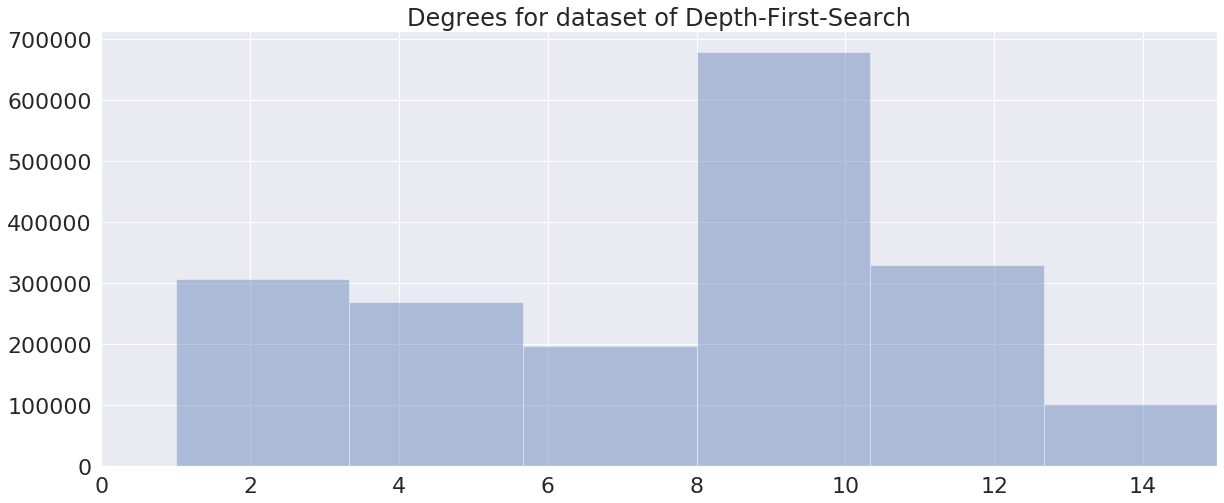

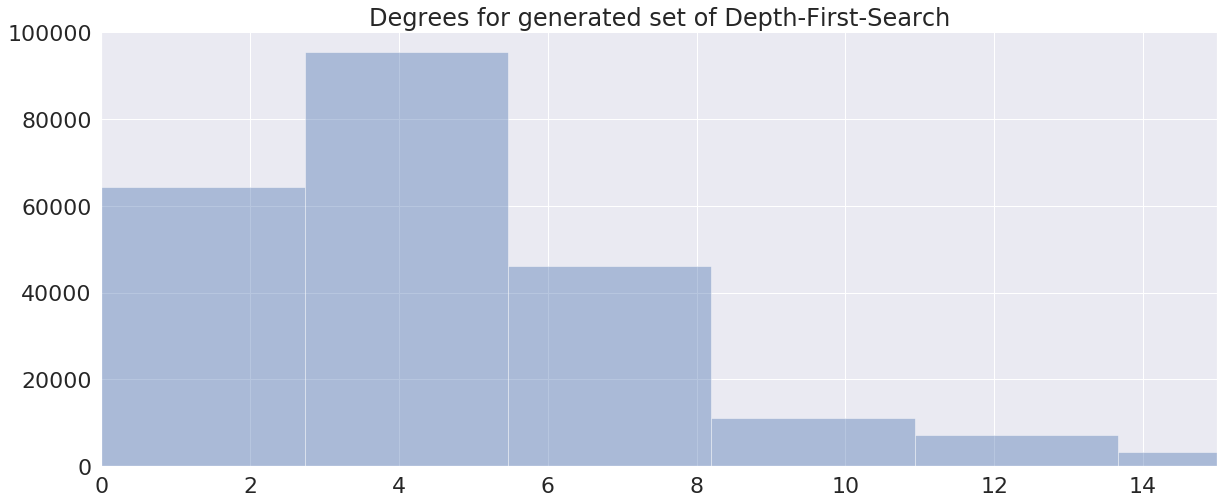

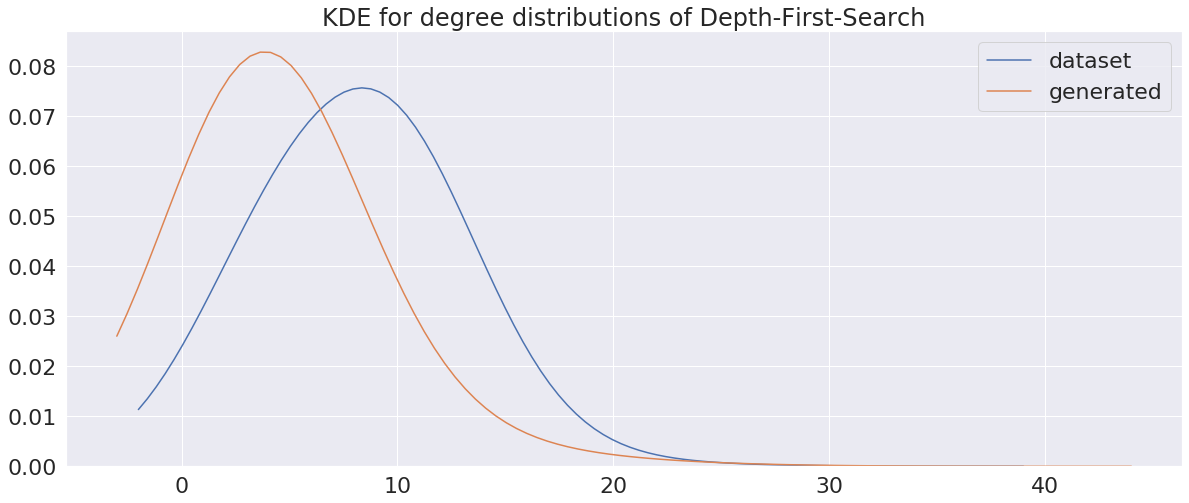

100%|██████████| 24/24 [00:14<00:00,  1.62it/s]

Considering 24000 graphs in merged datasets
Ignored 1454 generated graphs which are considered too small
Considering 3346 generated graphs
[array([10,  8, 10, ...,  9,  7,  9]), array([11, 11, 11, ..., 12, 10, 10]), array([ 7,  6, 11, ...,  6,  3,  8]), array([ 9, 13,  9, ...,  6, 10,  8]), array([19, 12,  8, ...,  8,  5,  4])]
[array([ 6,  7,  6, ...,  6, 10,  9]), array([10, 14,  7, ...,  2,  3,  0]), array([15, 25, 15, ...,  1,  0,  0]), array([10, 14,  2, ...,  1,  2,  1]), array([9, 3, 3, ..., 0, 1, 0])]


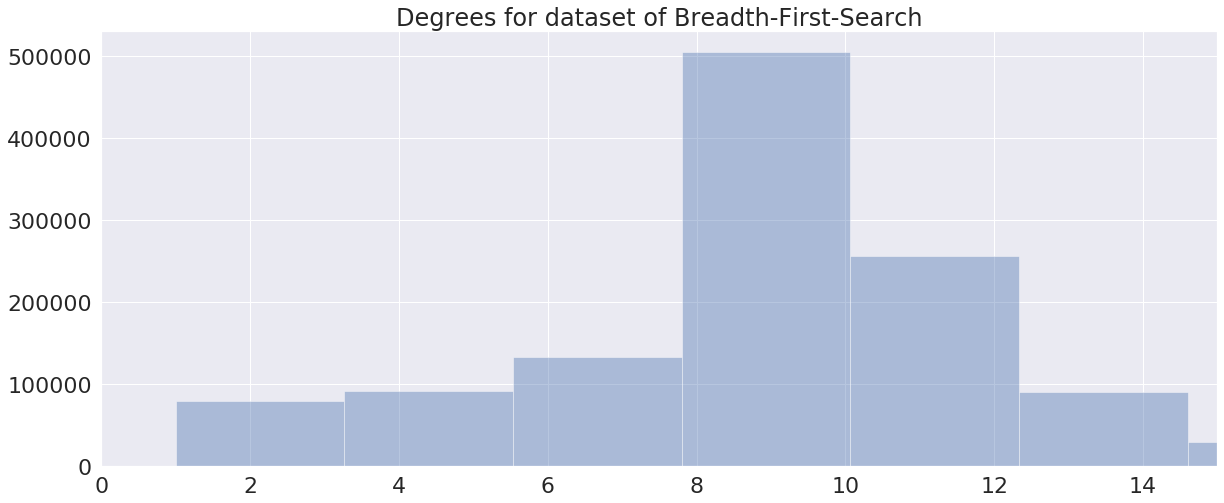

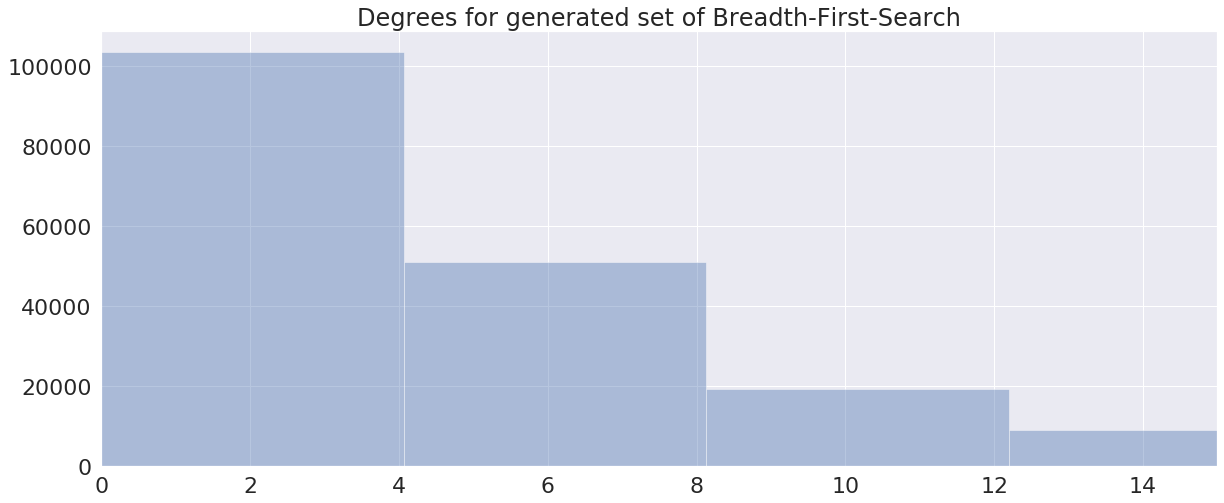

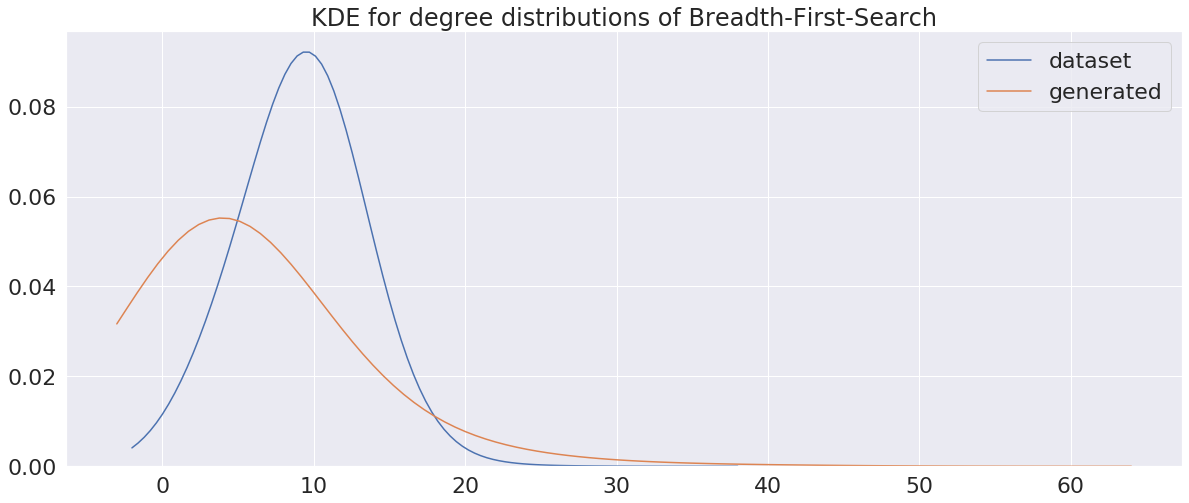

100%|██████████| 6/6 [00:02<00:00,  2.09it/s]

Considering 6000 graphs in merged datasets
Ignored 345 generated graphs which are considered too small
Considering 855 generated graphs
[array([10, 16, 12, ...,  3,  3,  3]), array([11,  2, 11, ...,  3,  3,  3]), array([ 5, 13, 14, ...,  3,  3,  3]), array([13, 20,  4, ...,  3,  3,  3]), array([ 5,  1, 16, ...,  3,  3,  3])]
[array([10,  7,  8, ...,  3,  2,  0]), array([4, 1, 4, ..., 1, 0, 0]), array([9, 8, 7, ..., 2, 2, 0]), array([7, 6, 3, ..., 3, 1, 0]), array([ 9,  5, 14, ...,  2,  2,  0])]


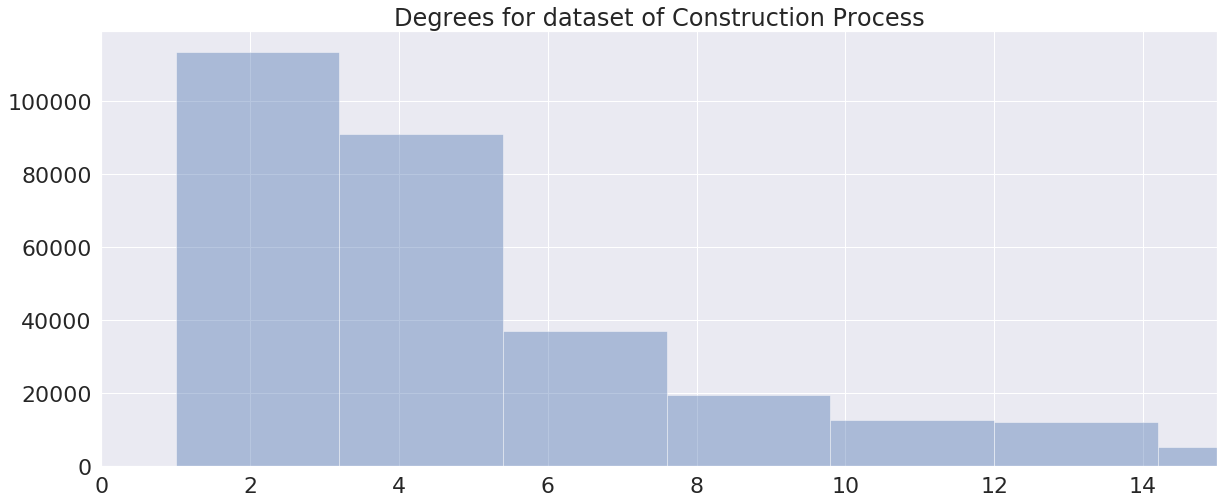

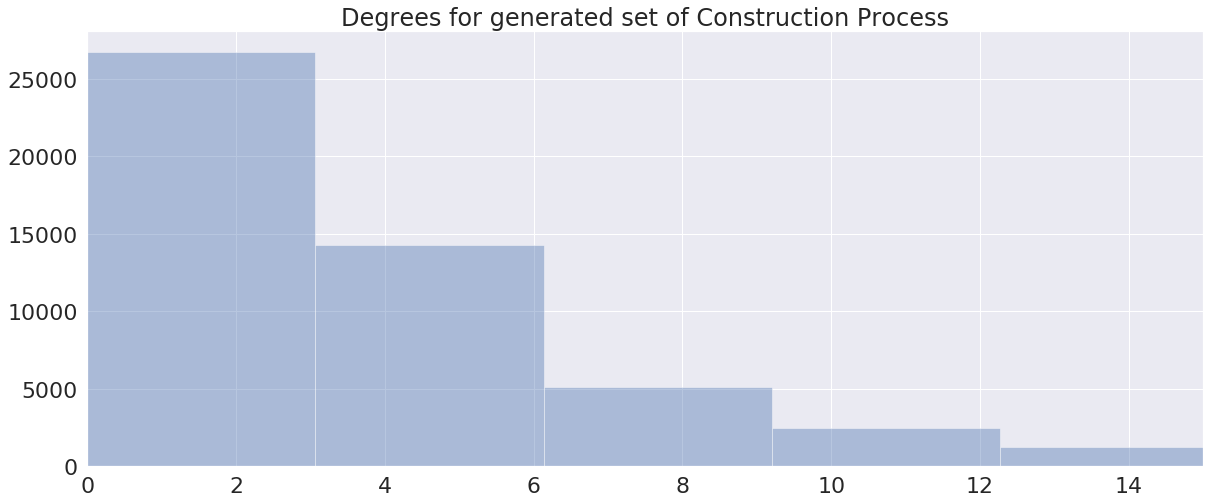

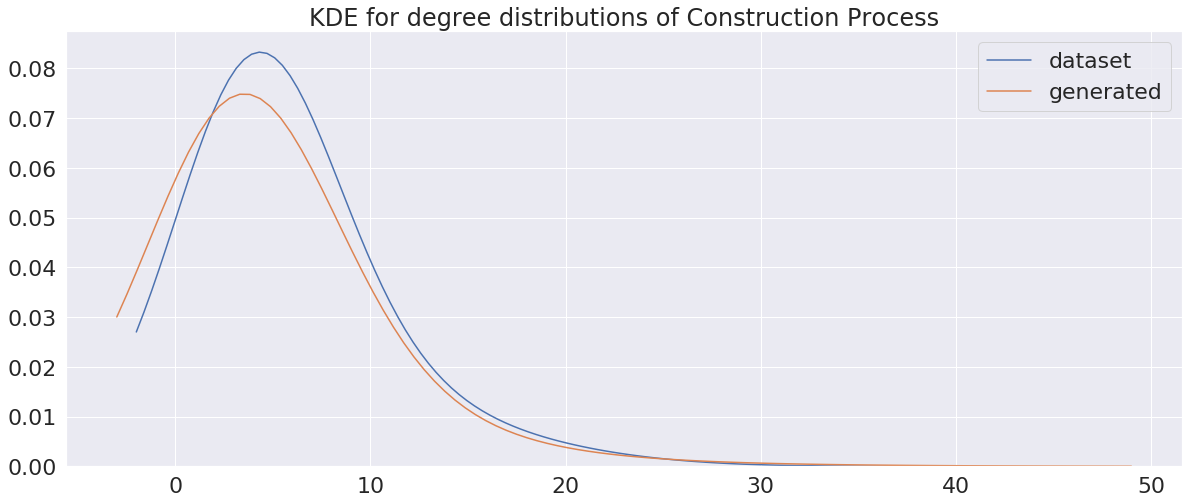

100%|██████████| 24/24 [00:14<00:00,  1.62it/s]

Considering 24000 graphs in merged datasets
Ignored 1649 generated graphs which are considered too small
Considering 3151 generated graphs
[array([ 7,  6, 11, ...,  6,  3,  8]), array([ 9, 13,  9, ...,  6, 10,  8]), array([19, 12,  8, ...,  8,  5,  4]), array([11,  6, 14, ...,  7,  7,  6]), array([15, 13,  7, ...,  6,  7,  7])]
[array([15, 25, 15, ...,  1,  0,  0]), array([10, 14,  2, ...,  1,  2,  1]), array([9, 3, 3, ..., 0, 1, 0]), array([10,  6,  8, ...,  2,  2,  2]), array([9, 7, 8, ..., 7, 6, 1])]


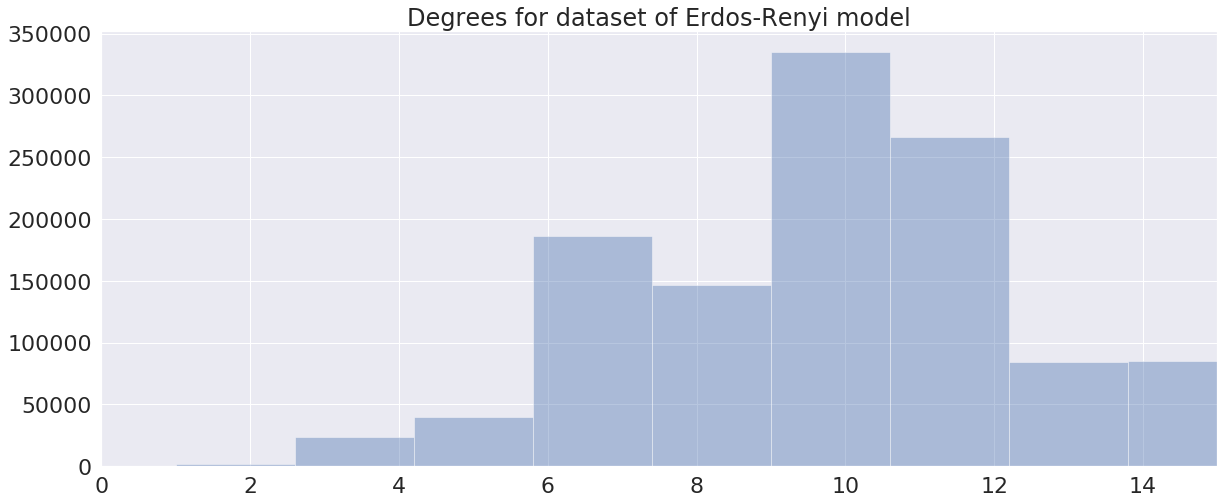

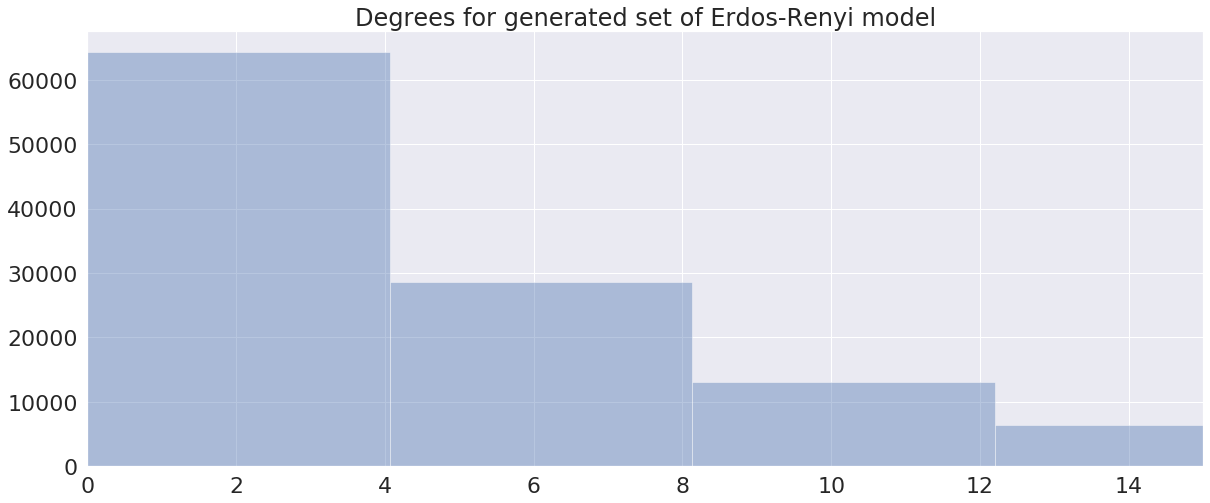

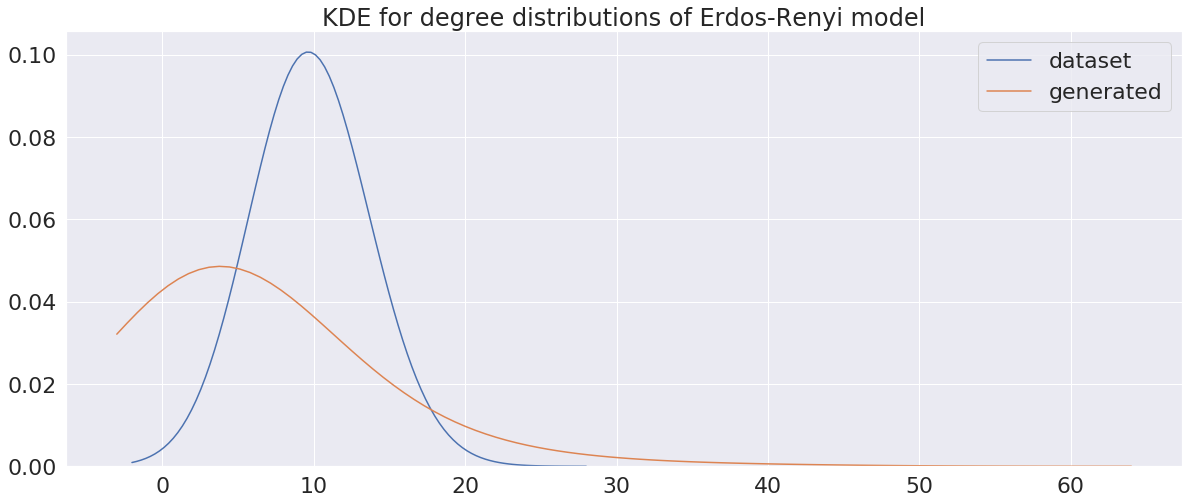

100%|██████████| 26/26 [00:13<00:00,  1.87it/s]

Considering 26000 graphs in merged datasets
Ignored 1624 generated graphs which are considered too small
Considering 3576 generated graphs
[array([ 5,  5, 10, ...,  5,  4,  4]), array([ 4, 20, 15, ...,  3,  3,  3]), array([10, 16, 12, ...,  3,  3,  3]), array([11,  2, 11, ...,  3,  3,  3]), array([15, 13,  6, ...,  3,  3,  4])]
[array([4, 5, 4, ..., 5, 7, 6]), array([1, 3, 7, ..., 1, 5, 3]), array([10,  7,  8, ...,  3,  2,  0]), array([4, 1, 4, ..., 1, 0, 0]), array([2, 5, 4, ..., 3, 5, 2])]


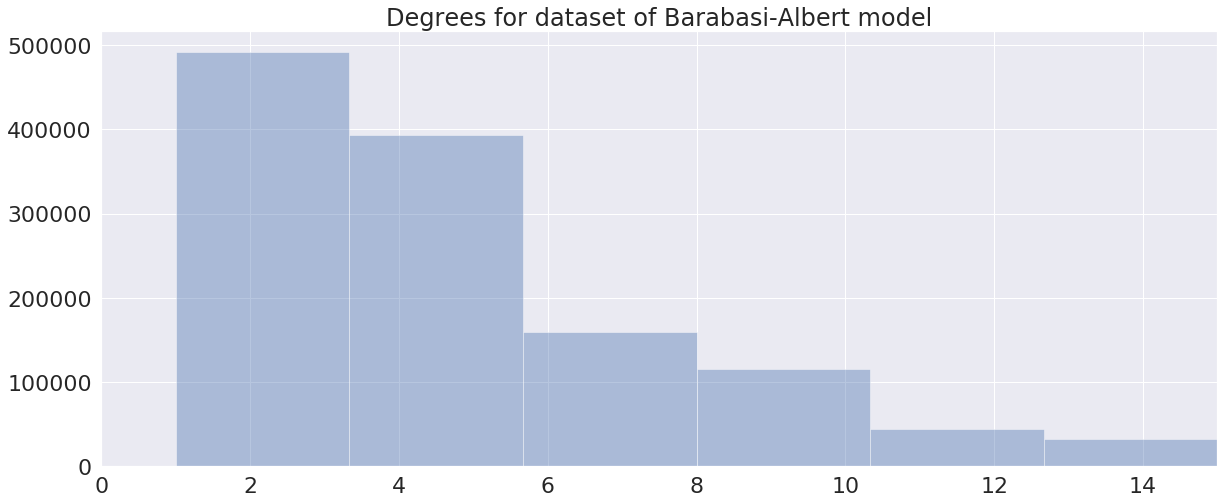

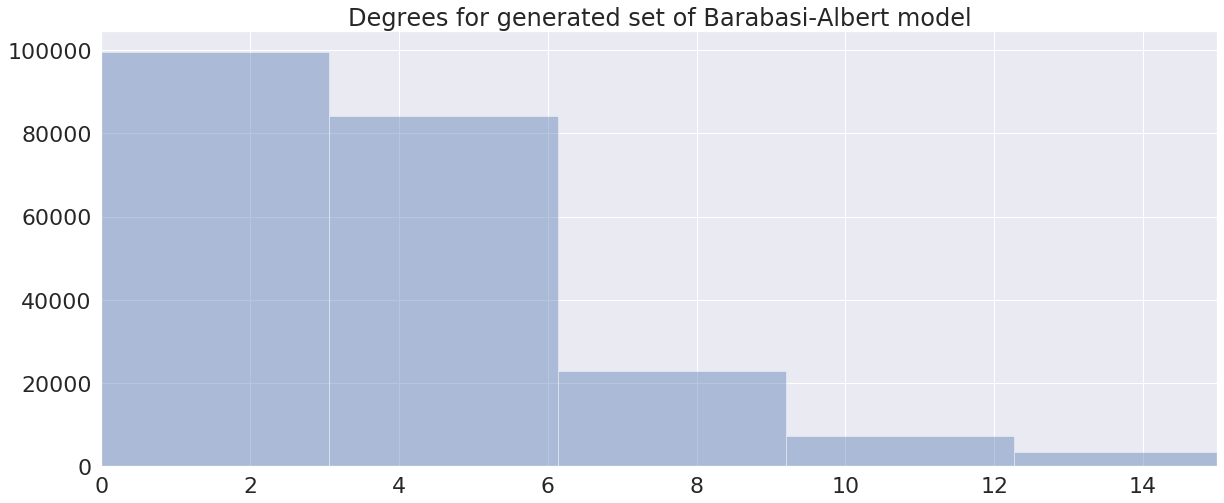

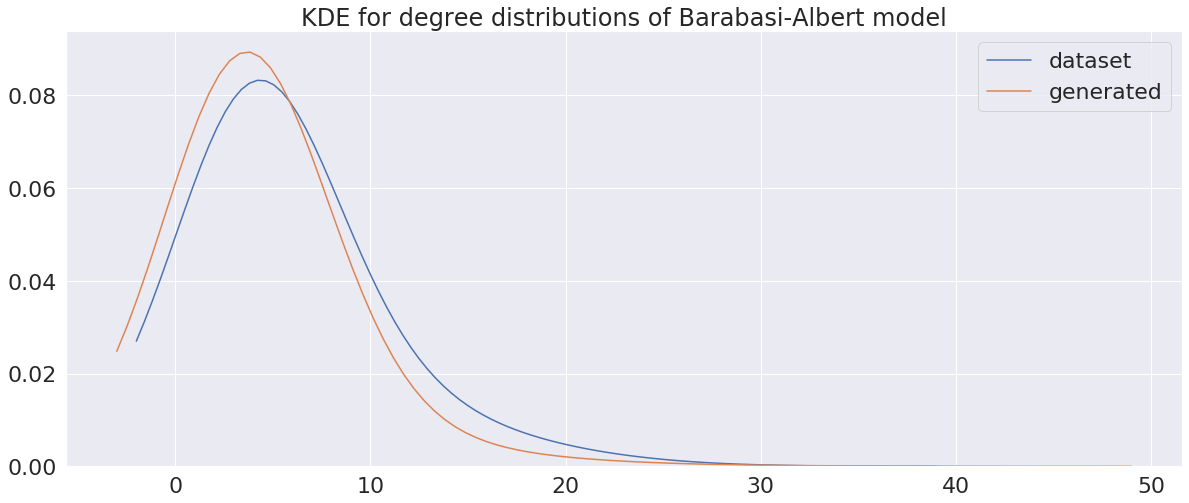

100%|██████████| 19/19 [00:12<00:00,  1.55it/s]

Considering 19000 graphs in merged datasets
Ignored 1196 generated graphs which are considered too small
Considering 2604 generated graphs
[array([ 9, 10, 10, ...,  9, 10,  9]), array([10,  8, 10, ...,  9,  7,  9]), array([11, 11, 11, ..., 12, 10, 10]), array([10,  9,  9, ..., 10,  9, 10]), array([14,  9, 10, ..., 10,  9, 10])]
[array([7, 8, 9, ..., 2, 2, 2]), array([ 6,  7,  6, ...,  6, 10,  9]), array([10, 14,  7, ...,  2,  3,  0]), array([0, 3, 5, ..., 3, 6, 6]), array([21, 29, 16, ...,  2,  1,  2])]


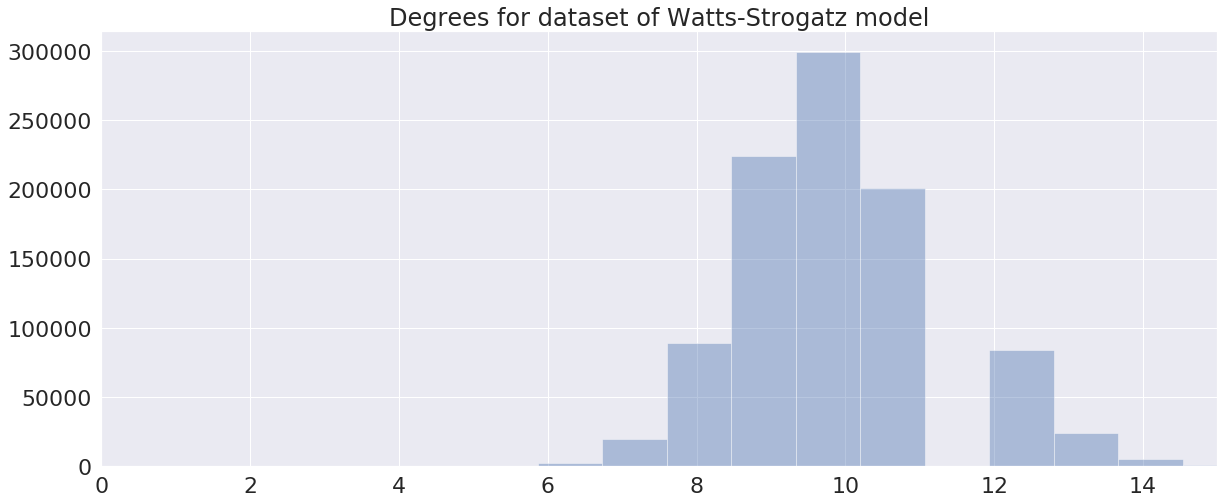

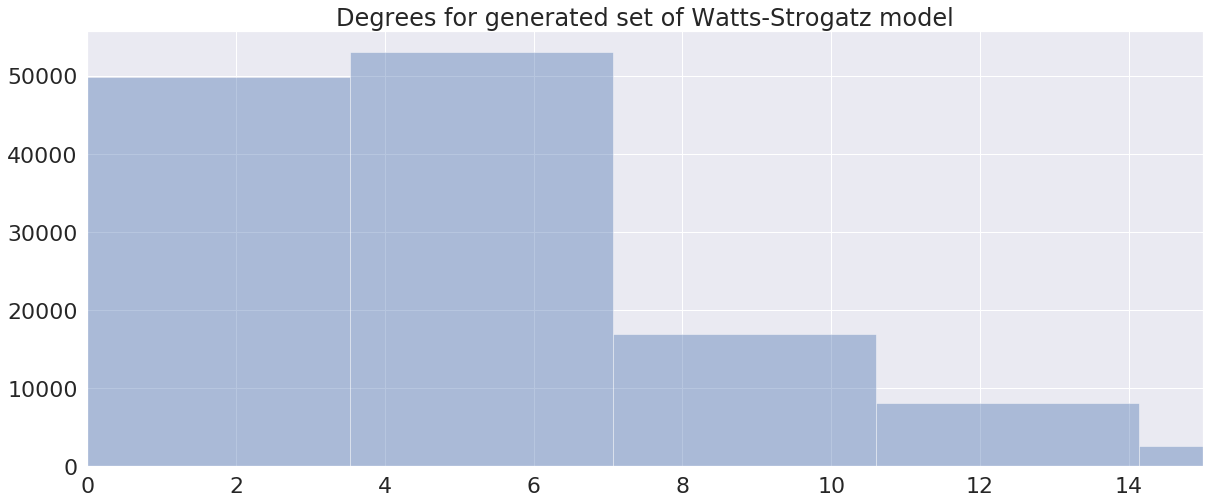

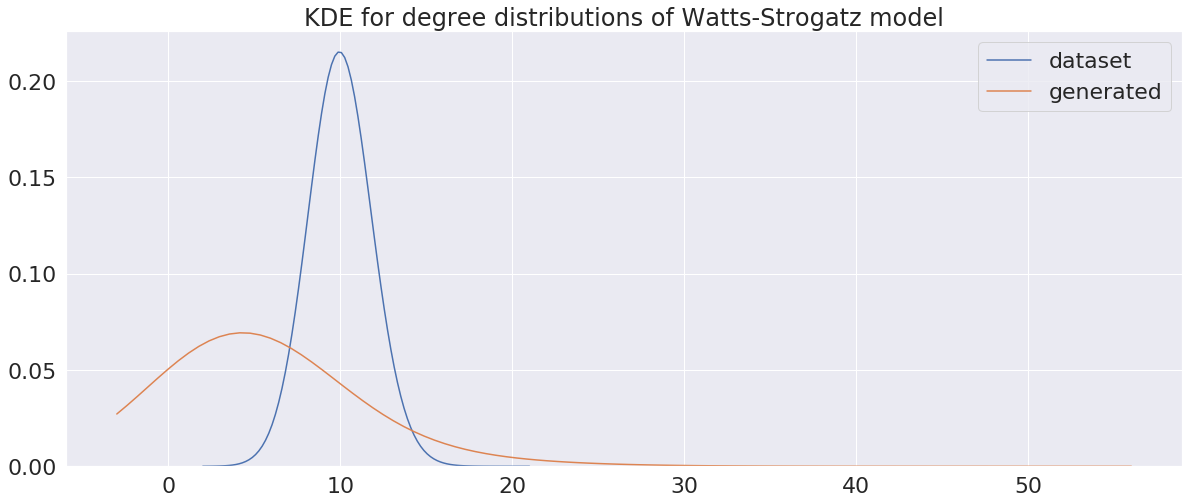

100%|██████████| 13/13 [00:08<00:00,  1.59it/s]

Considering 13000 graphs in merged datasets
Ignored 842 generated graphs which are considered too small
Considering 1758 generated graphs
[array([ 7,  6, 11, ...,  6,  3,  8]), array([ 9, 13,  9, ...,  6, 10,  8]), array([19, 12,  8, ...,  8,  5,  4]), array([13, 14, 10, ...,  7,  7,  9]), array([11,  8, 16, ..., 10,  7,  5])]
[array([15, 25, 15, ...,  1,  0,  0]), array([10, 14,  2, ...,  1,  2,  1]), array([9, 3, 3, ..., 0, 1, 0]), array([ 2, 11, 13, ...,  0,  0,  0]), array([12, 12, 14, ...,  0,  0,  0])]


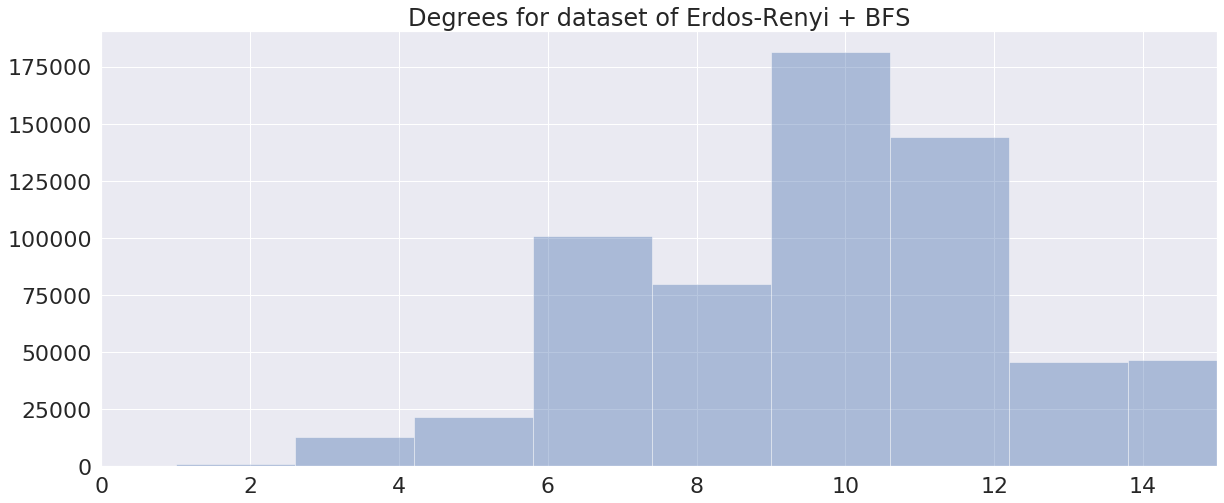

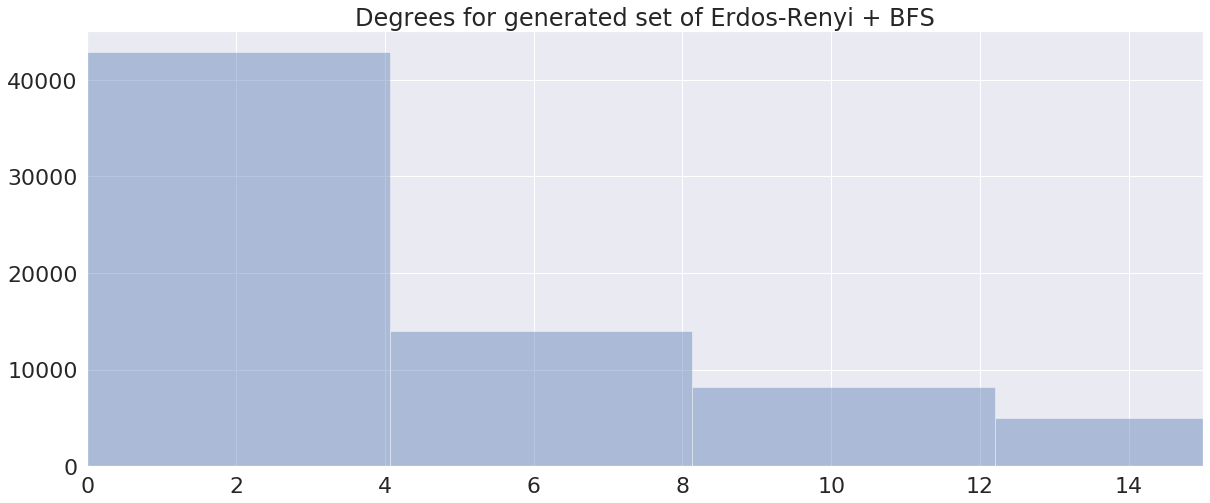

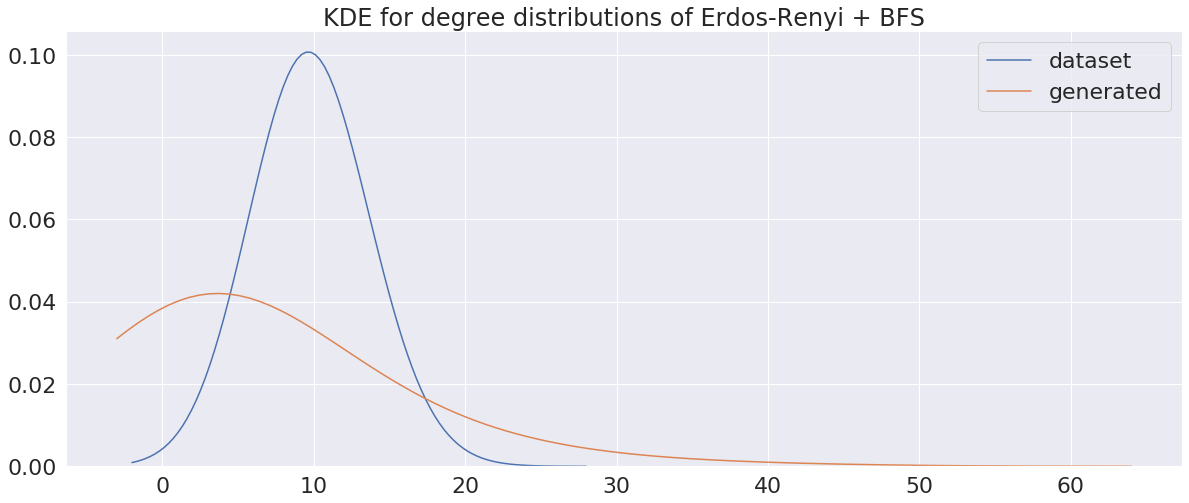

100%|██████████| 11/11 [00:06<00:00,  1.62it/s]

Considering 11000 graphs in merged datasets
Ignored 807 generated graphs which are considered too small
Considering 1393 generated graphs
[array([11,  6, 14, ...,  7,  7,  6]), array([15, 13,  7, ...,  6,  7,  7]), array([11, 13, 14, ...,  5,  8,  5]), array([ 5,  9,  7, ...,  6, 14,  8]), array([10,  8,  6, ...,  7, 10,  6])]
[array([10,  6,  8, ...,  2,  2,  2]), array([9, 7, 8, ..., 7, 6, 1]), array([ 3,  4,  3, ..., 10,  8, 11]), array([ 4,  7,  7, ...,  9,  5, 10]), array([0, 6, 5, ..., 0, 0, 0])]


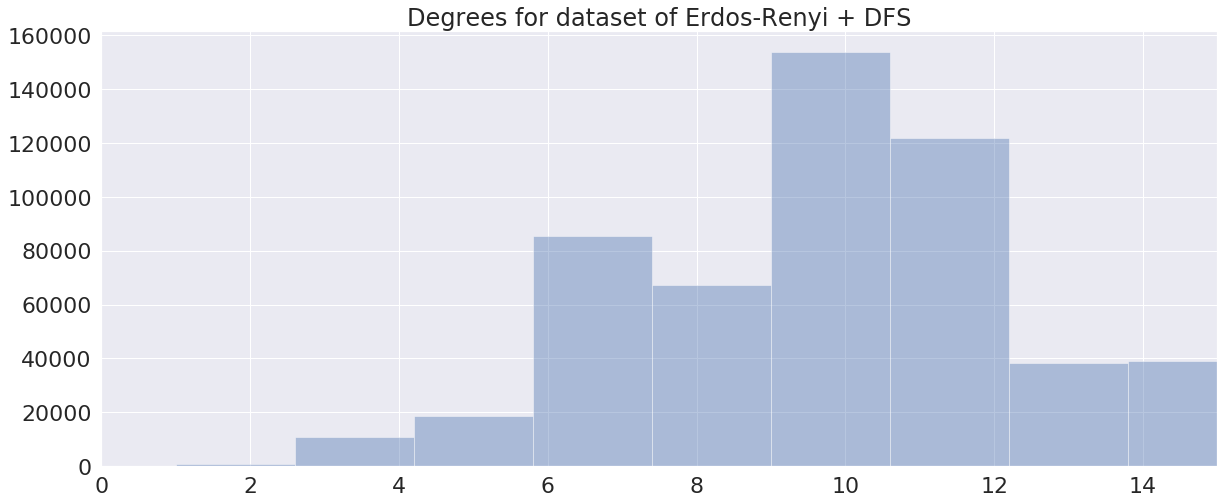

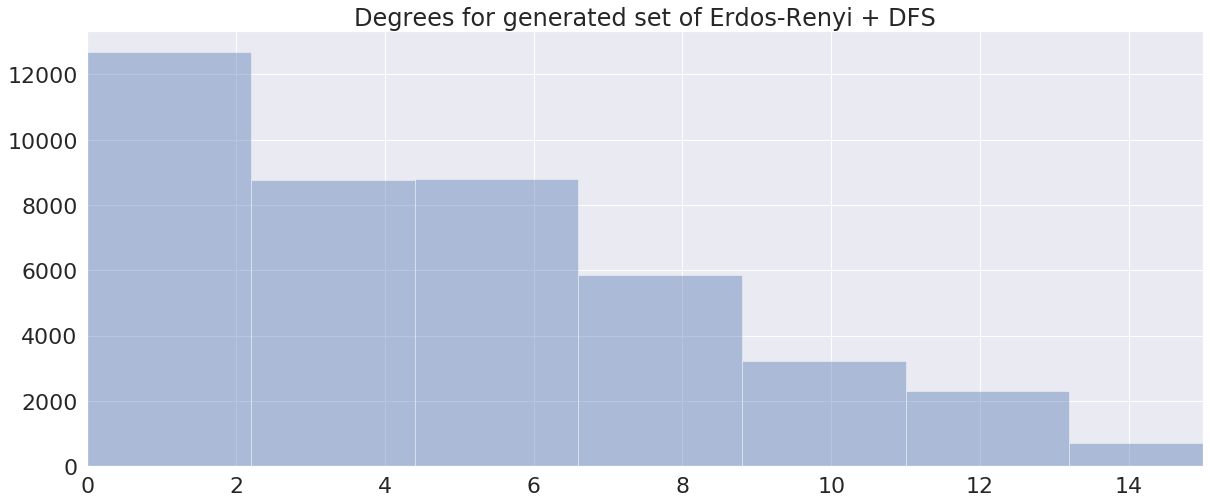

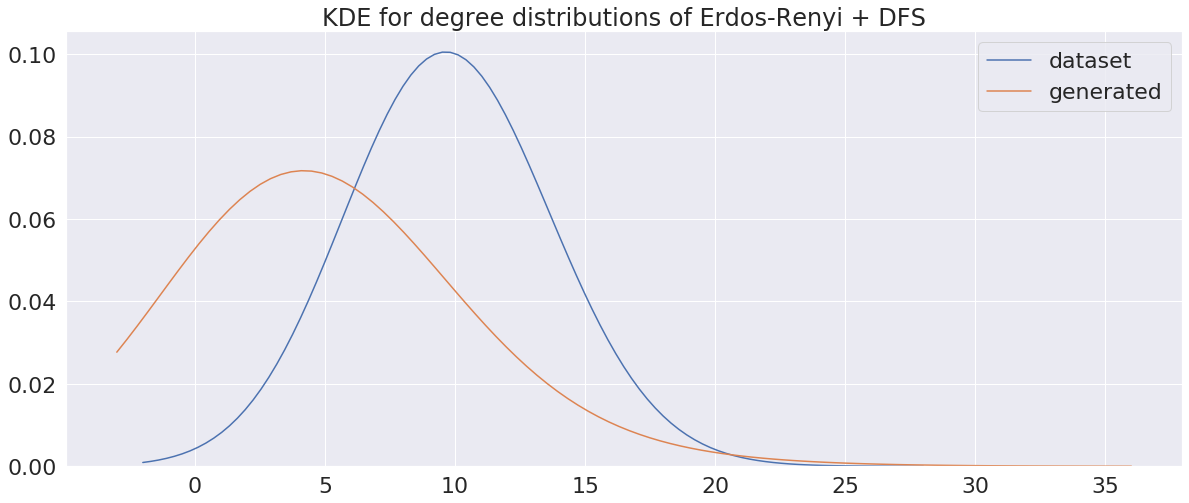

100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

Considering 4000 graphs in merged datasets
Ignored 211 generated graphs which are considered too small
Considering 589 generated graphs
[array([ 9, 10, 18, ...,  4,  3,  3]), array([ 5, 20, 19, ...,  3,  3,  3]), array([ 6, 18,  9, ...,  3,  3,  3]), array([ 5, 24,  8, ...,  3,  3,  4])]
[array([ 9, 14, 19, ...,  0,  1,  0]), array([9, 6, 3, ..., 0, 0, 0]), array([2, 4, 7, ..., 4, 4, 4]), array([4, 3, 3, ..., 3, 3, 1])]


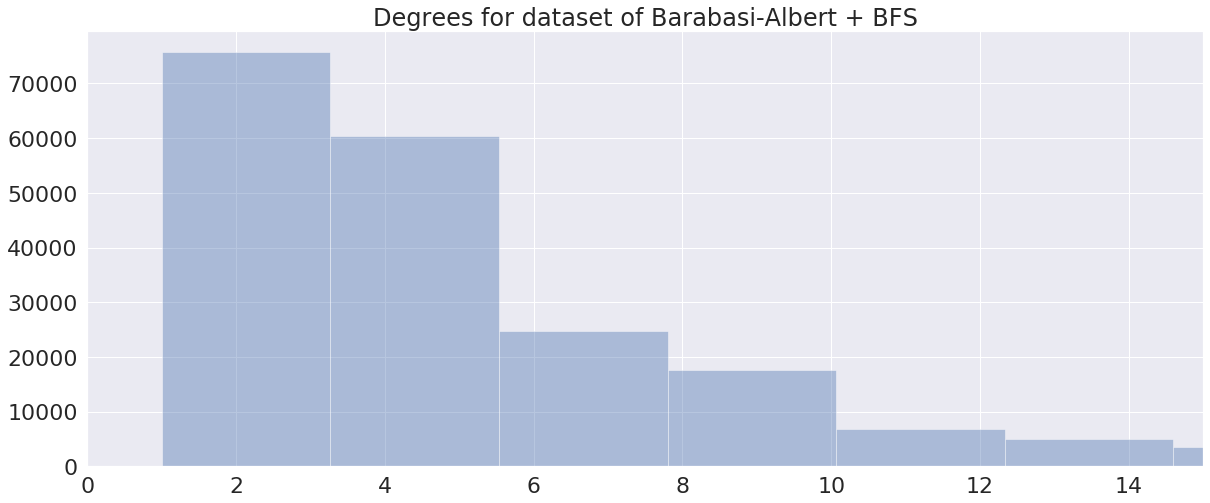

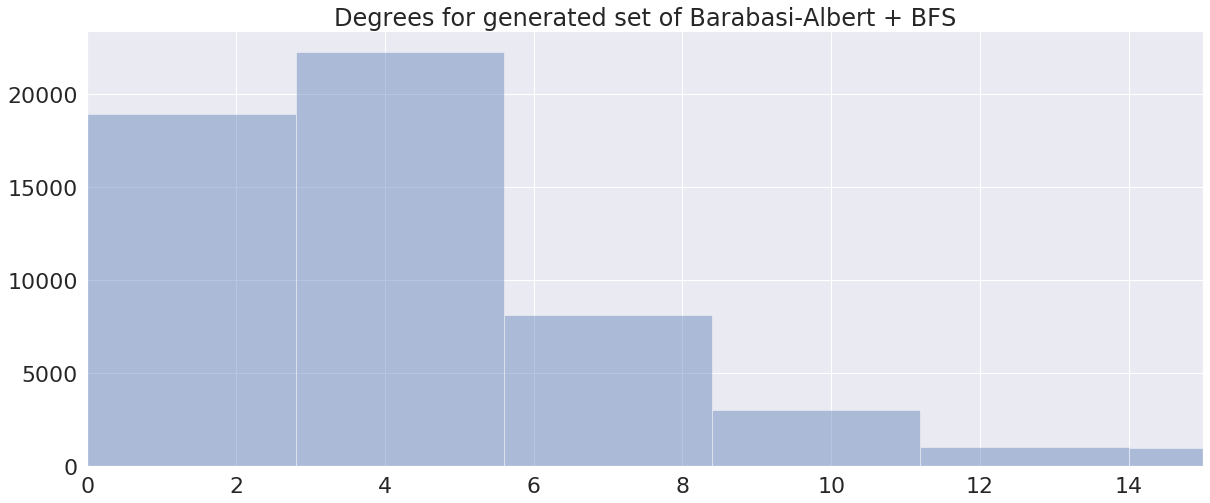

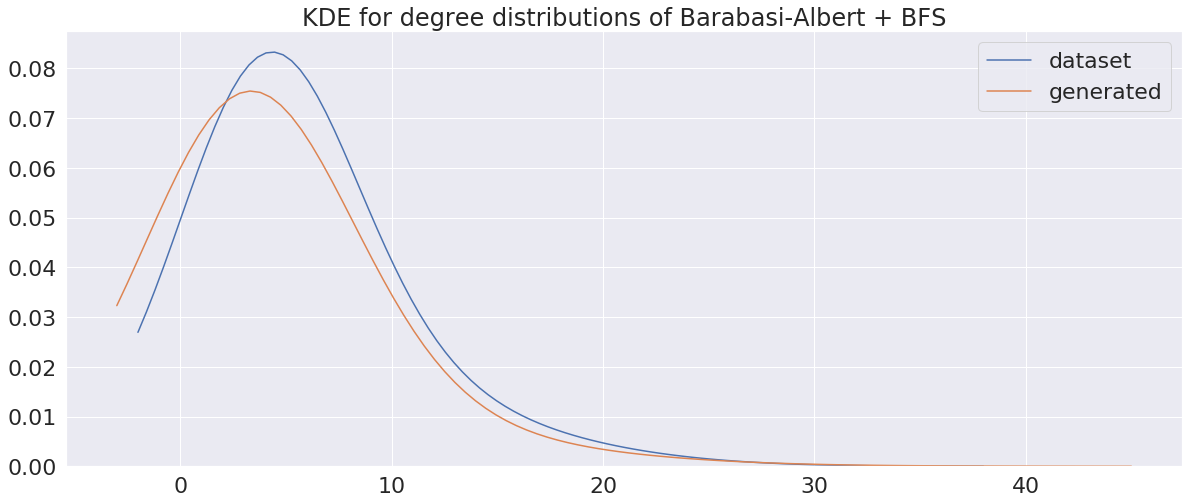

100%|██████████| 16/16 [00:08<00:00,  1.93it/s]

Considering 16000 graphs in merged datasets
Ignored 1068 generated graphs which are considered too small
Considering 2132 generated graphs
[array([ 5,  5, 10, ...,  5,  4,  4]), array([ 4, 20, 15, ...,  3,  3,  3]), array([15, 13,  6, ...,  3,  3,  4]), array([ 3, 21, 17, ...,  6,  3,  3]), array([ 3, 13, 22, ...,  3,  3,  3])]
[array([4, 5, 4, ..., 5, 7, 6]), array([1, 3, 7, ..., 1, 5, 3]), array([2, 5, 4, ..., 3, 5, 2]), array([6, 7, 7, ..., 0, 0, 0]), array([2, 5, 6, ..., 2, 4, 4])]


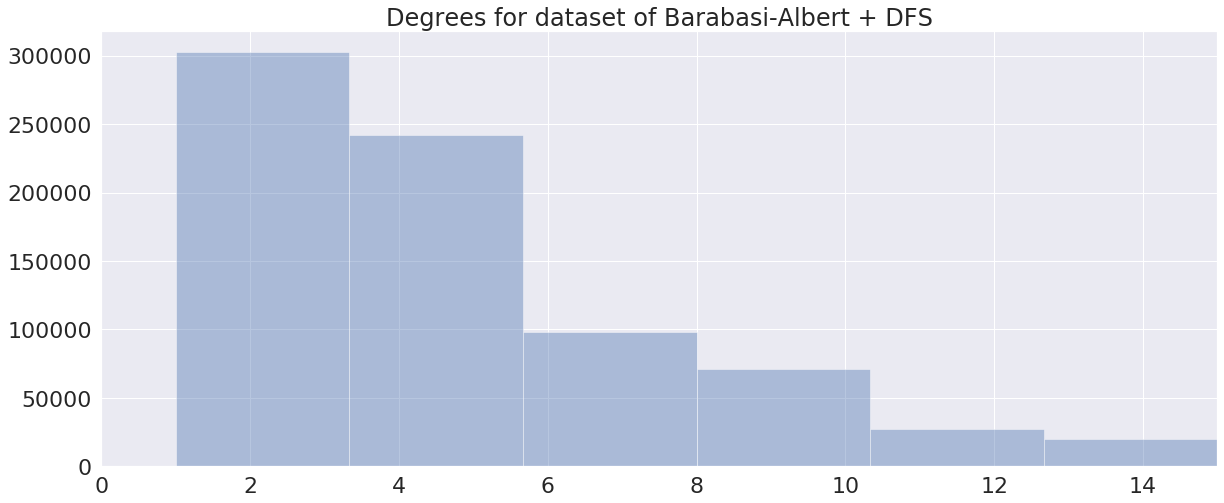

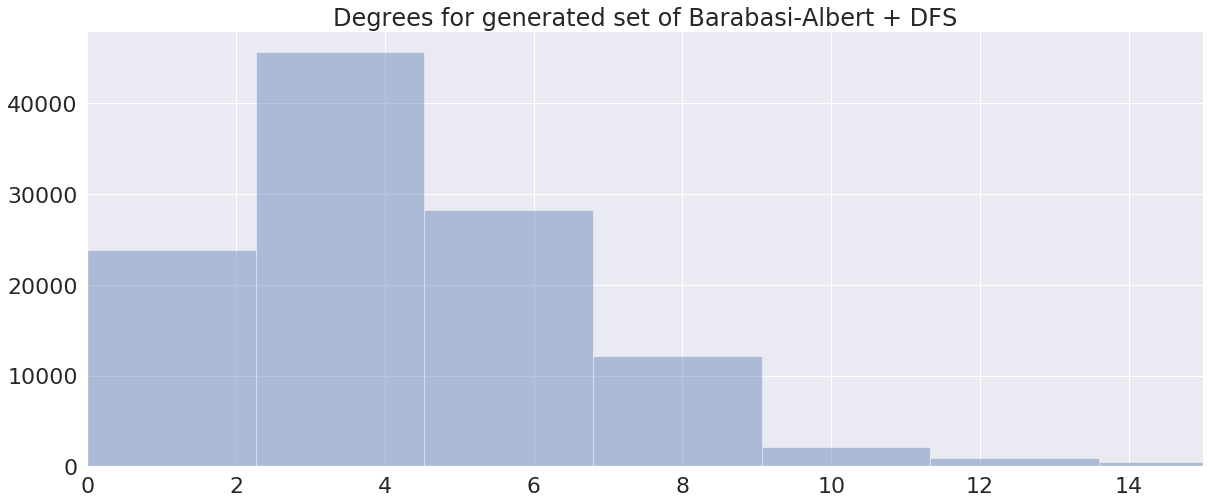

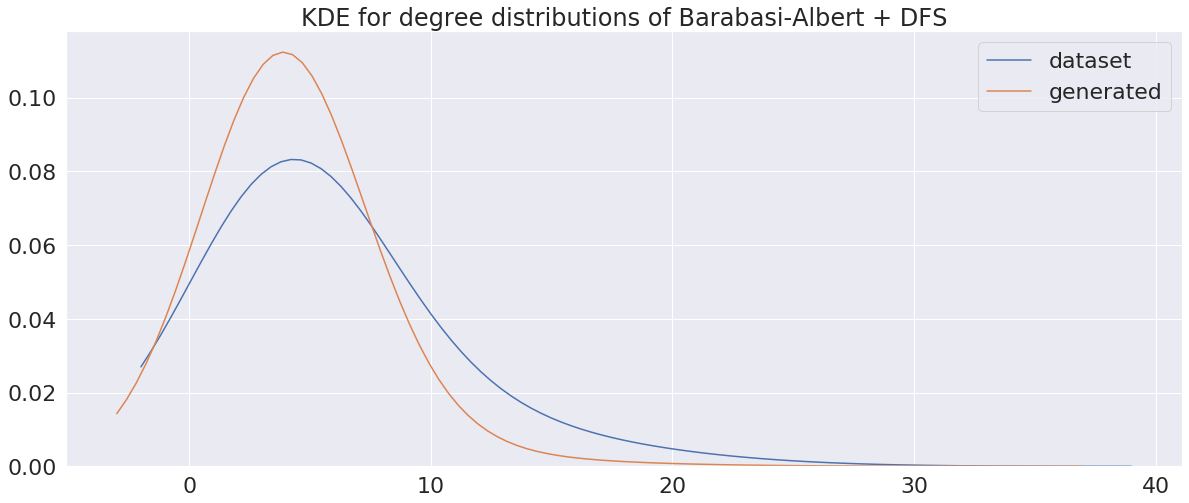

100%|██████████| 7/7 [00:04<00:00,  1.47it/s]

Considering 7000 graphs in merged datasets
Ignored 401 generated graphs which are considered too small
Considering 999 generated graphs
[array([10,  8, 10, ...,  9,  7,  9]), array([11, 11, 11, ..., 12, 10, 10]), array([ 6, 10, 10, ..., 10,  9, 11]), array([12,  9,  9, ..., 10, 10, 10]), array([10, 10, 10, ...,  8,  9,  9])]
[array([ 6,  7,  6, ...,  6, 10,  9]), array([10, 14,  7, ...,  2,  3,  0]), array([ 7,  2,  6, ..., 13,  9, 19]), array([4, 4, 6, ..., 1, 3, 0]), array([4, 7, 3, ..., 6, 7, 4])]


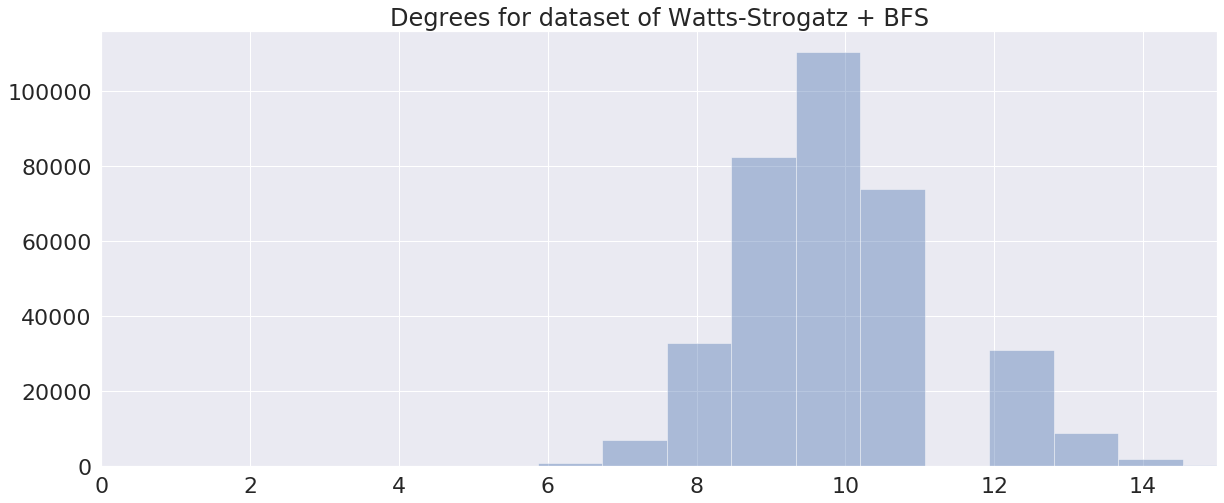

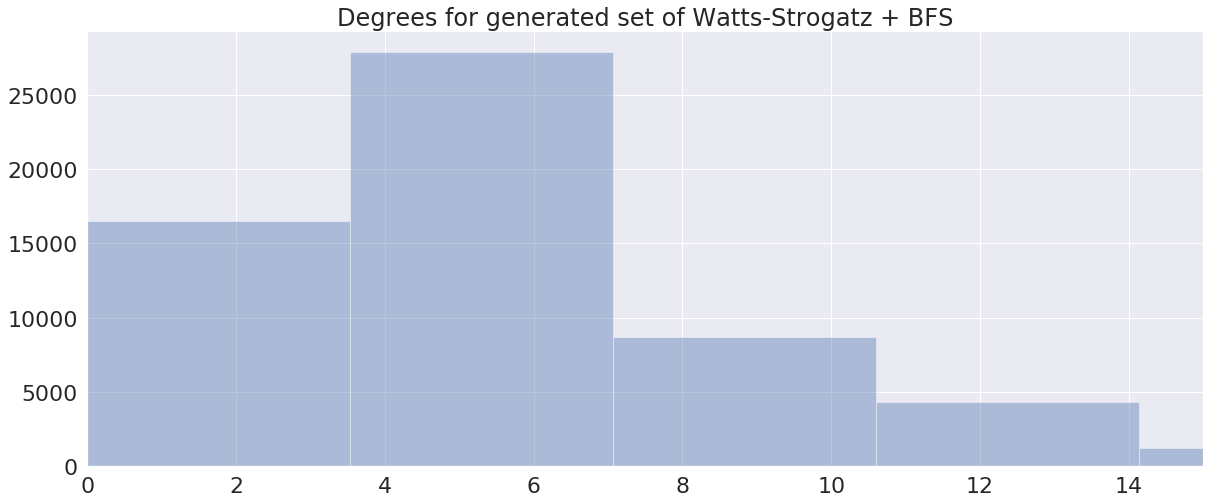

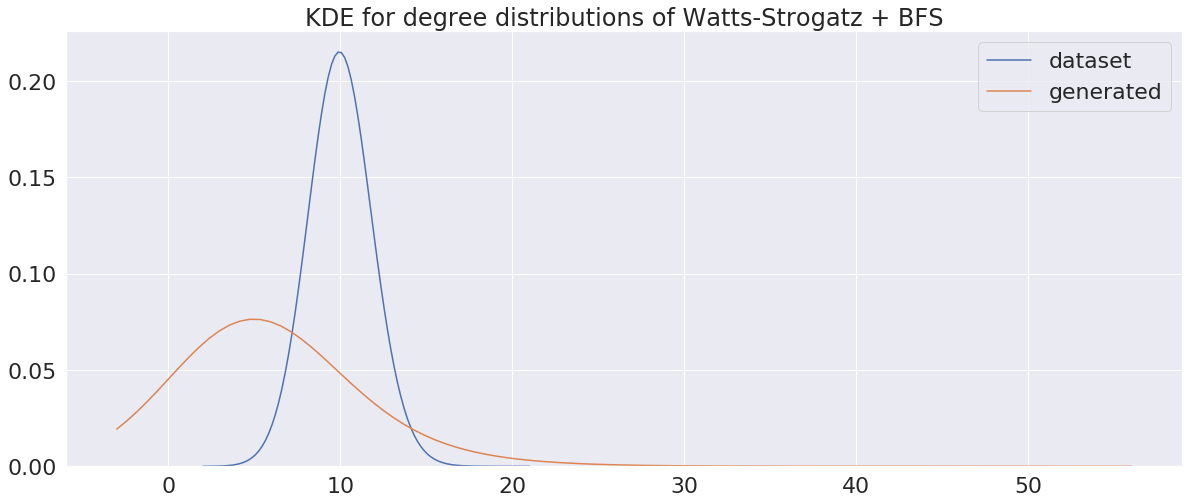

100%|██████████| 12/12 [00:07<00:00,  1.62it/s]

Considering 12000 graphs in merged datasets
Ignored 795 generated graphs which are considered too small
Considering 1605 generated graphs
[array([ 9, 10, 10, ...,  9, 10,  9]), array([10,  9,  9, ..., 10,  9, 10]), array([14,  9, 10, ..., 10,  9, 10]), array([10, 13, 10, ...,  9, 11,  8]), array([ 9, 11, 11, ..., 10, 10,  9])]
[array([7, 8, 9, ..., 2, 2, 2]), array([0, 3, 5, ..., 3, 6, 6]), array([21, 29, 16, ...,  2,  1,  2]), array([ 9, 15,  4, ...,  0,  0,  0]), array([ 4,  5,  7, ...,  9, 10, 13])]


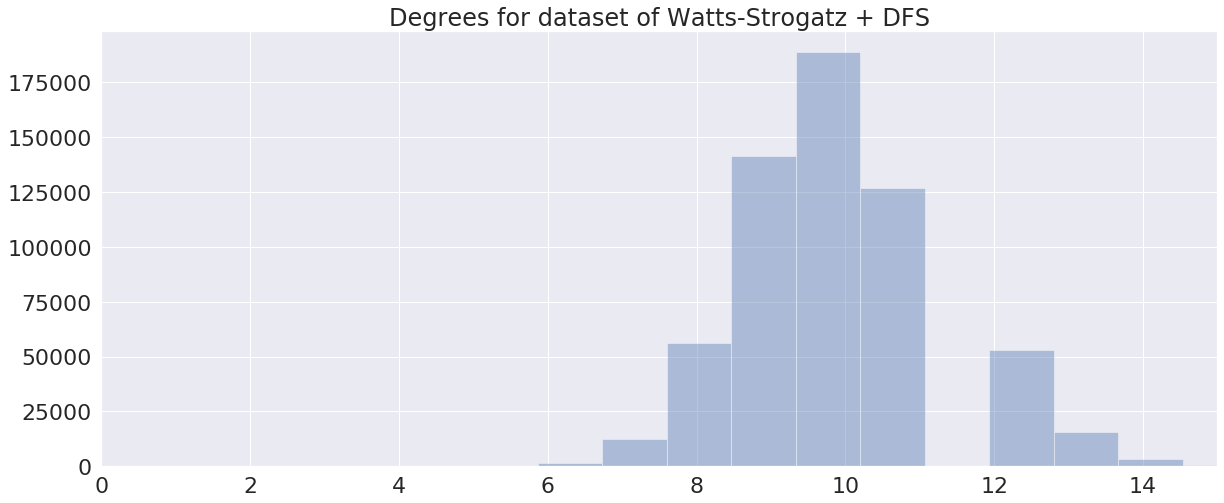

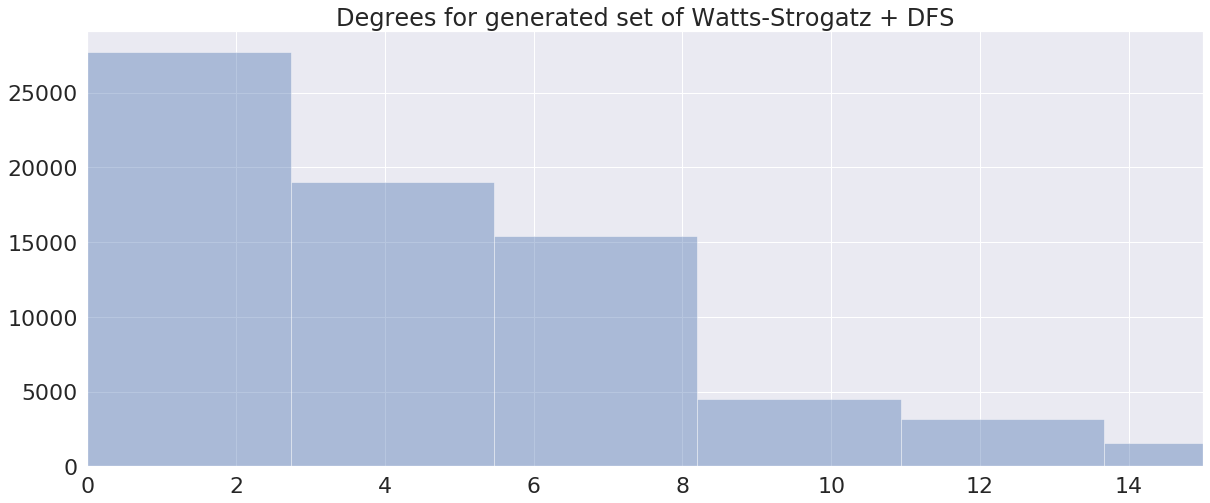

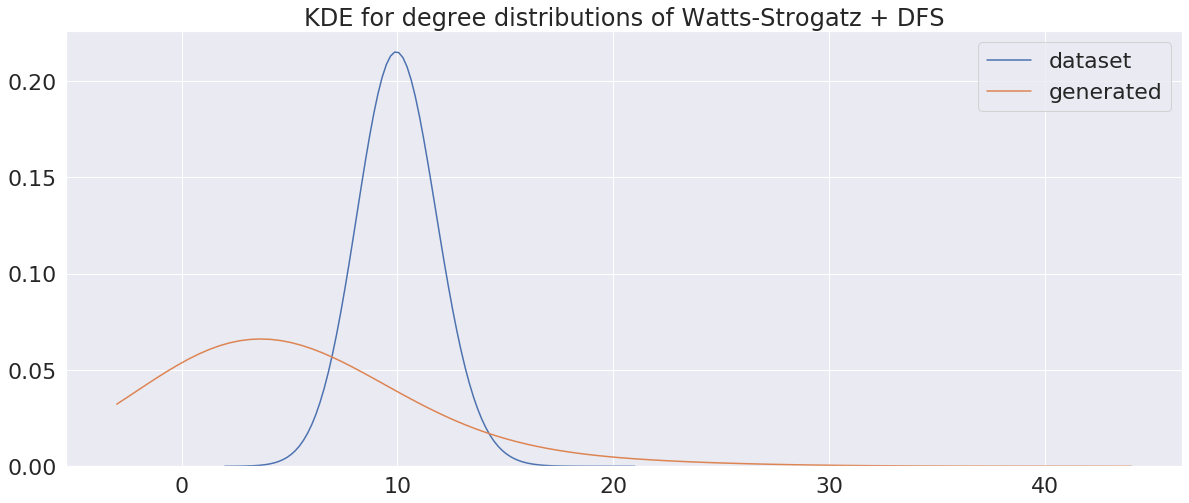

In [86]:
for subset_name in subsets:
    compare_degree_distribution_of(subsets[subset_name], subset_name)

100%|██████████| 39/39 [00:22<00:00,  1.73it/s]


Considering 39000 graphs in merged datasets
Ignored 2670 generated graphs which are considered too small
Considering 5130 generated graphs


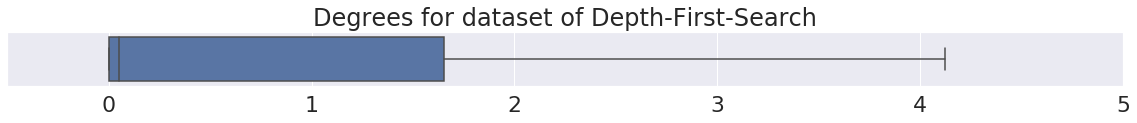

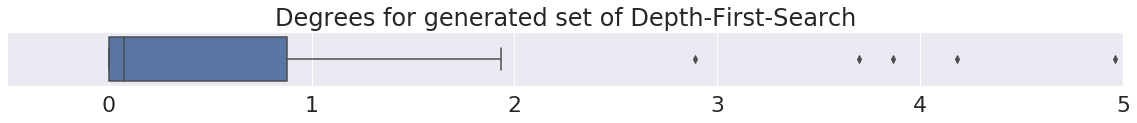

100%|██████████| 24/24 [00:14<00:00,  1.63it/s]


Considering 24000 graphs in merged datasets
Ignored 1454 generated graphs which are considered too small
Considering 3346 generated graphs


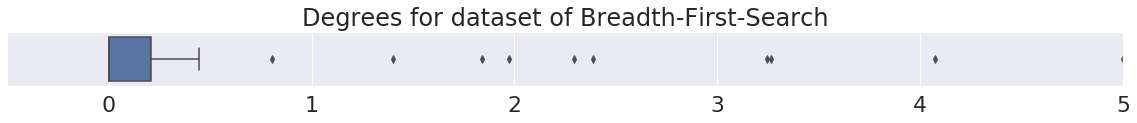

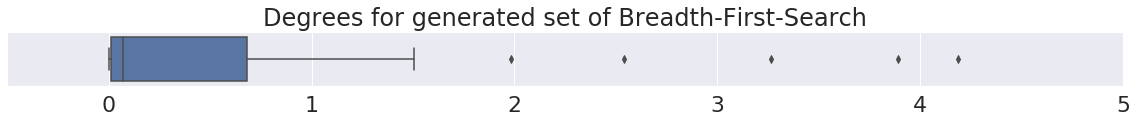

100%|██████████| 6/6 [00:03<00:00,  1.86it/s]


Considering 6000 graphs in merged datasets
Ignored 345 generated graphs which are considered too small
Considering 855 generated graphs


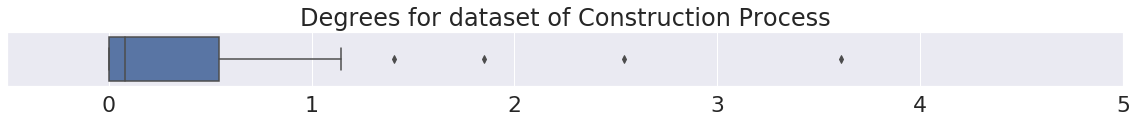

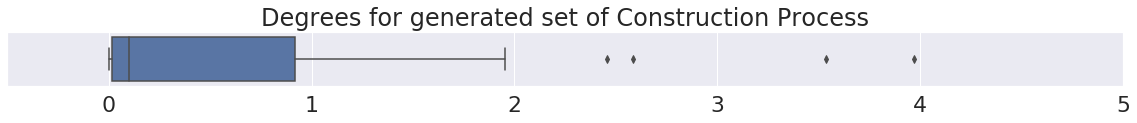

100%|██████████| 24/24 [00:14<00:00,  1.61it/s]


Considering 24000 graphs in merged datasets
Ignored 1649 generated graphs which are considered too small
Considering 3151 generated graphs


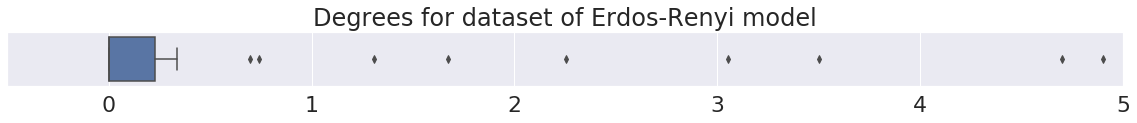

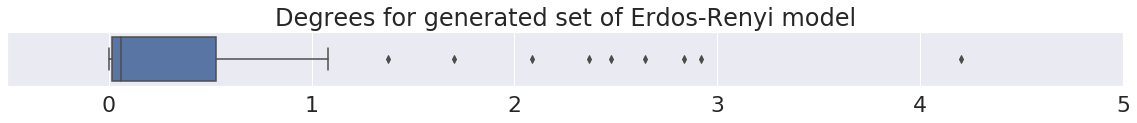

100%|██████████| 26/26 [00:13<00:00,  1.89it/s]


Considering 26000 graphs in merged datasets
Ignored 1624 generated graphs which are considered too small
Considering 3576 generated graphs


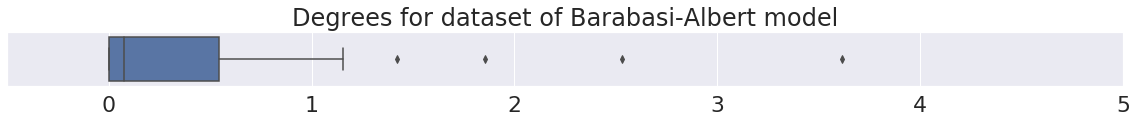

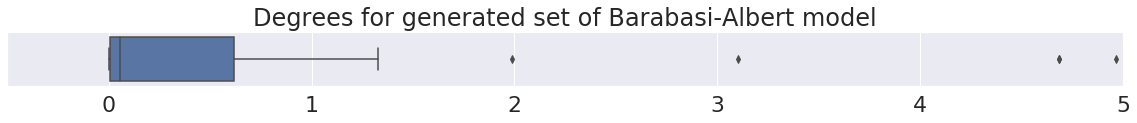

100%|██████████| 19/19 [00:12<00:00,  1.55it/s]


Considering 19000 graphs in merged datasets
Ignored 1196 generated graphs which are considered too small
Considering 2604 generated graphs


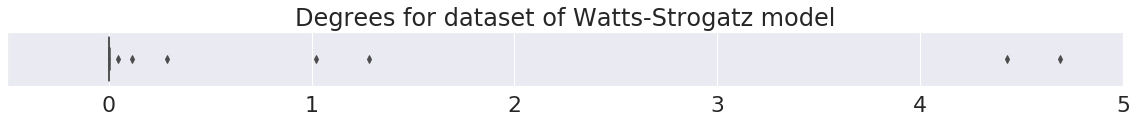

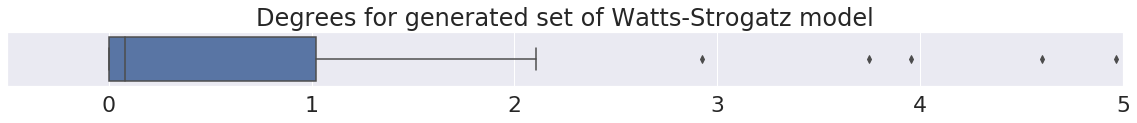

100%|██████████| 13/13 [00:08<00:00,  1.53it/s]


Considering 13000 graphs in merged datasets
Ignored 842 generated graphs which are considered too small
Considering 1758 generated graphs


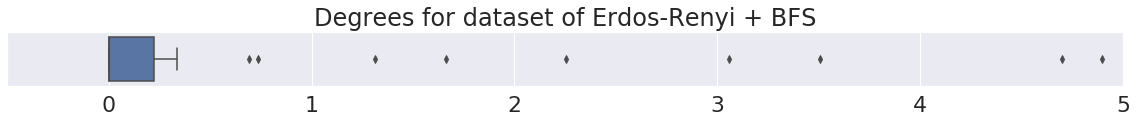

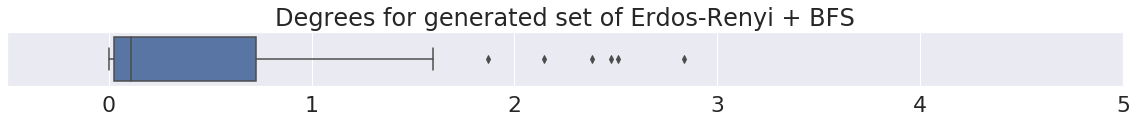

100%|██████████| 11/11 [00:06<00:00,  1.66it/s]


Considering 11000 graphs in merged datasets
Ignored 807 generated graphs which are considered too small
Considering 1393 generated graphs


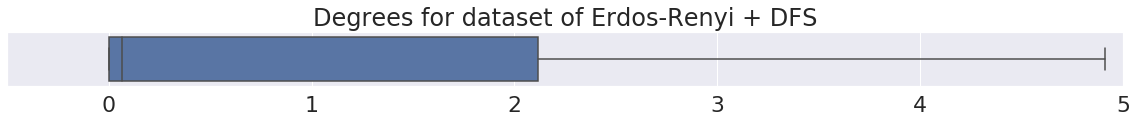

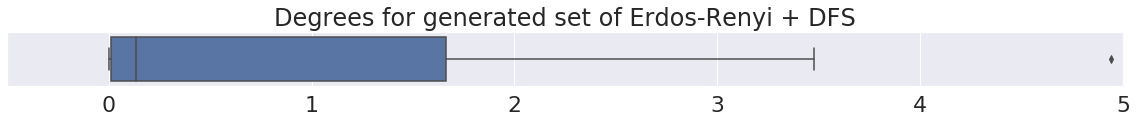

100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


Considering 4000 graphs in merged datasets
Ignored 211 generated graphs which are considered too small
Considering 589 generated graphs


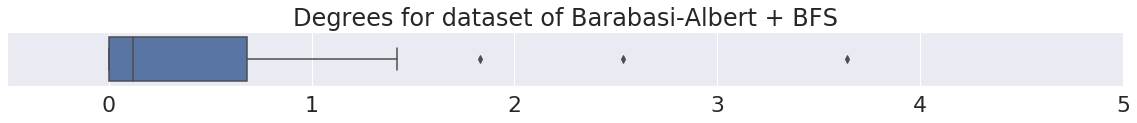

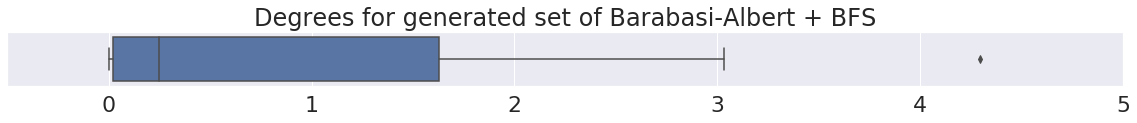

100%|██████████| 16/16 [00:08<00:00,  1.95it/s]


Considering 16000 graphs in merged datasets
Ignored 1068 generated graphs which are considered too small
Considering 2132 generated graphs


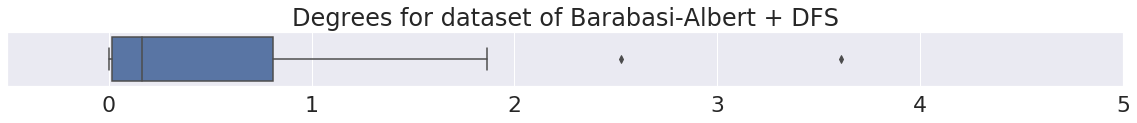

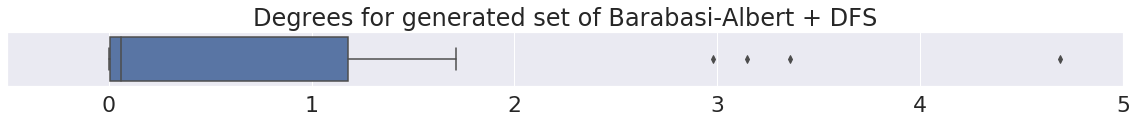

100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


Considering 7000 graphs in merged datasets
Ignored 401 generated graphs which are considered too small
Considering 999 generated graphs


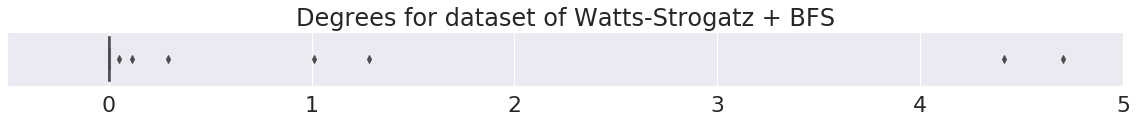

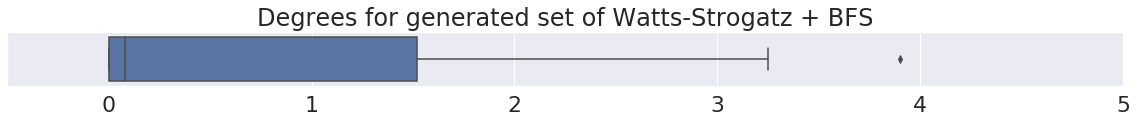

100%|██████████| 12/12 [00:07<00:00,  1.59it/s]


Considering 12000 graphs in merged datasets
Ignored 795 generated graphs which are considered too small
Considering 1605 generated graphs


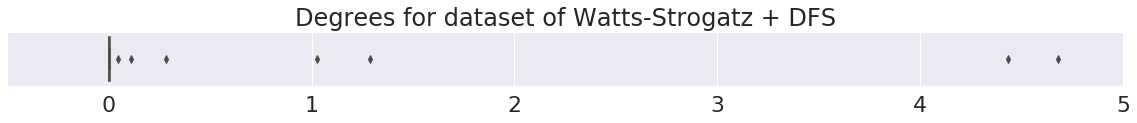

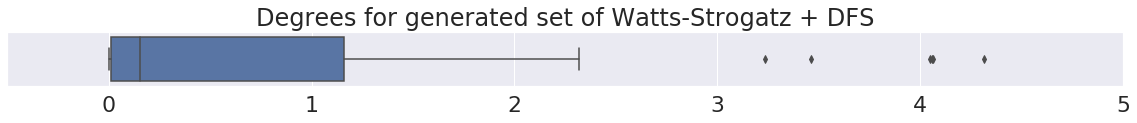

In [34]:
for subset_name in subsets:
    compare_degree_distribution_of(subsets[subset_name], subset_name)